In [1]:
from tsai.all import *
import sklearn.metrics as skm

from IPython.display import clear_output
computer_setup()

os              : Windows-10-10.0.22621-SP0
python          : 3.8.15
tsai            : 0.3.4
fastai          : 2.7.10
fastcore        : 1.5.27
torch           : 1.9.1+cu111
device          : 1 gpu (['NVIDIA GeForce RTX 2070 SUPER'])
cpu cores       : 8
threads per cpu : 2
RAM             : 31.92 GB
GPU memory      : [8.0] GB


### Resteaze Data

In [2]:
# Read the two csv files as one
df1 = pd.read_csv('final_processed.csv')
df2 = pd.read_csv('final_test_processed.csv')
data = pd.concat([df1, df2], ignore_index=True)

data.tail()

Unnamed: 0  level_0      index     unixTimes  accelerometerX  \
10250997     1069496  2138992  1067814.5  1.644671e+12         -257.75   
10250998     1069497  2138994  1067816.5  1.644671e+12         -262.50   
10250999     1069498  2138996  1067818.5  1.644671e+12         -258.75   
10251000     1069499  2138998  1067820.5  1.644671e+12         -258.00   
10251001     1069500  2139000  1067822.5  1.644671e+12         -258.50   

          accelerometerY  accelerometerZ  gyroscopeX  gyroscopeY  gyroscopeZ  \
10250997          676.50         3972.75     -220.25      -57.50      116.50   
10250998          671.25         3971.00     -217.00      -58.25      134.75   
10250999          674.50         3972.25     -219.00      -73.00      116.00   
10251000          679.50         3972.50     -214.00      -62.00      124.00   
10251001          682.00         3972.25     -202.00      -49.00      143.00   

          ...               sdsd      rmssd     pnn20     pnn50  hr_mad  \
10250997  ...                NaN        NaN       NaN       NaN     NaN   
10250998  ...                NaN        NaN       NaN       NaN     NaN   
10250999  ...                NaN        NaN       NaN       NaN     NaN   
10251000  ...                NaN        NaN       NaN       NaN     NaN   
10251001  ...  56.37246376805148  94.058805  0.823529  0.558824    40.0   

                sd1        sd2             s   sd1/sd2  breathingrate  
10250997        NaN        NaN           NaN       NaN            NaN  
10250998        NaN        NaN           NaN       NaN            NaN  
10250999        NaN        NaN           NaN       NaN            NaN  
10251000        NaN        NaN           NaN       NaN            NaN  
10251001  66.322062  50.382619  10497.566473  1.316368       0.402635  

[5 rows x 25 columns]

In [3]:
df = data.copy()

df = df[df.sleep_state != -1]

# Binary Classification
df["sleep_state"] = np.where(df["sleep_state"] == 0, 0, 1)

# fill NaN values
df = df.fillna(method='bfill', limit=1500).dropna()

# # set column time as datetime index
# df['time'] = pd.to_datetime(df['time'])
# df = df.set_index('time', drop=True)

df = df[['ledGreen', 'bpm', 'rmssd', 'pnn20', 'pnn50', 'hr_mad', 'sd1', 'sd2', 'accelerometerX', 'accelerometerY', 'accelerometerZ', 'gyroscopeX', 'gyroscopeY', 'gyroscopeZ', 'sleep_state']]


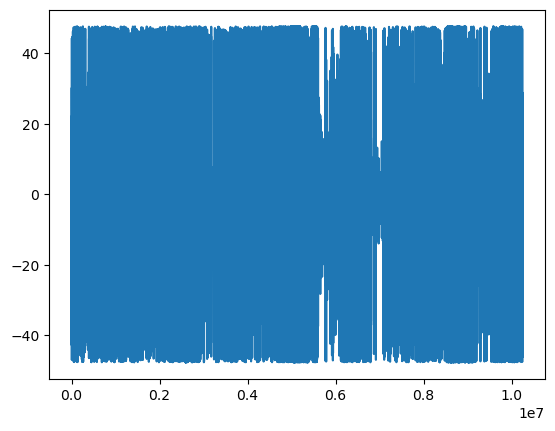

In [4]:
# df = ((df + df.shift(-1)) / 2)[::2]

# remove extreme values from the signal (outliers)


def remove_extreme_values(signal, threshold):
    # Compute the absolute difference between the signal and its mean
    absolute_difference = np.abs(signal - np.mean(signal))
    # Compute the median of the absolute difference
    median_absolute_difference = np.median(absolute_difference)
    # Compute the median absolute deviation
    median_absolute_deviation = 1.4826 * median_absolute_difference
    # Compute the z-score
    z_score = 0.6745 * (absolute_difference / median_absolute_deviation)
    # Remove the extreme values
    signal = signal[z_score < threshold]
    return signal


# Example usage
filtered_ppg = remove_extreme_values(df['ledGreen'], threshold=3.0)
filtered_bpm = remove_extreme_values(df['bpm'], threshold=3.0)
filtered_rmssd = remove_extreme_values(df['rmssd'], threshold=3.0)
filtered_pnn20 = remove_extreme_values(df['pnn20'], threshold=3.0)
filtered_pnn50 = remove_extreme_values(df['pnn50'], threshold=3.0)
filtered_hr_mad = remove_extreme_values(df['hr_mad'], threshold=3.0)
filtered_sd1 = remove_extreme_values(df['sd1'], threshold=3.0)
filtered_sd2 = remove_extreme_values(df['sd2'], threshold=3.0)
filtered_accelerometerX = remove_extreme_values(df['accelerometerX'], threshold=3.0)
filtered_accelerometerY = remove_extreme_values(df['accelerometerY'], threshold=3.0)
filtered_accelerometerZ = remove_extreme_values(df['accelerometerZ'], threshold=3.0)
filtered_gyroscopeX = remove_extreme_values(df['gyroscopeX'], threshold=3.0)
filtered_gyroscopeY = remove_extreme_values(df['gyroscopeY'], threshold=3.0)
filtered_gyroscopeZ = remove_extreme_values(df['gyroscopeZ'], threshold=3.0)


df['ledGreen'] = filtered_ppg
df['bpm'] = filtered_bpm
df['rmssd'] = filtered_rmssd
df['pnn20'] = filtered_pnn20
df['pnn50'] = filtered_pnn50
df['hr_mad'] = filtered_hr_mad
df['sd1'] = filtered_sd1
df['sd2'] = filtered_sd2
df['accelerometerX'] = filtered_accelerometerX
df['accelerometerY'] = filtered_accelerometerY
df['accelerometerZ'] = filtered_accelerometerZ
df['gyroscopeX'] = filtered_gyroscopeX
df['gyroscopeY'] = filtered_gyroscopeY
df['gyroscopeZ'] = filtered_gyroscopeZ

df = df.dropna()

plt.plot(filtered_ppg)

In [5]:
# Non null values in the dataset
df.isnull().sum()

ledGreen          0
bpm               0
rmssd             0
pnn20             0
pnn50             0
hr_mad            0
sd1               0
sd2               0
accelerometerX    0
accelerometerY    0
accelerometerZ    0
gyroscopeX        0
gyroscopeY        0
gyroscopeZ        0
sleep_state       0
dtype: int64

In [6]:
class_map = {
    0: 'WK',  # wake
    1: 'SL',  # sleep
}
class_map

{0: 'WK', 1: 'SL'}

<AxesSubplot:>

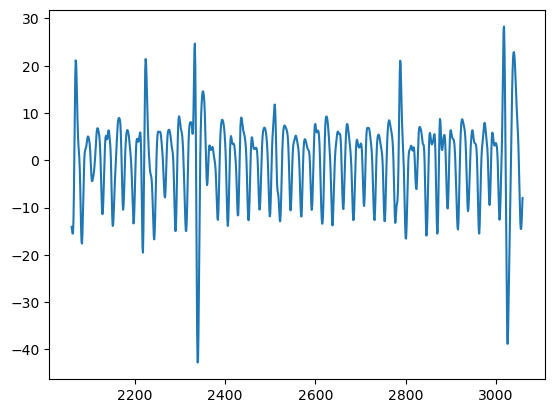

In [7]:
df['ledGreen'][2000:3000].plot()

# Filters and transforms

## TSData preparation

## Data from 3d array

In [8]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, LabelEncoder


scaler = StandardScaler()
le = LabelEncoder()

temp_df = df[['ledGreen', 'bpm', 'rmssd', 'pnn20', 'pnn50', 'hr_mad', 'sd1', 'sd2', 'accelerometerX', 'accelerometerY', 'accelerometerZ', 'gyroscopeX', 'gyroscopeY', 'gyroscopeZ', 'sleep_state']]
X = scaler.fit_transform(temp_df.drop('sleep_state', axis=1))
y = le.fit_transform(temp_df['sleep_state'])

# selecting sequences range
X = X[0:(len(X) - len(X) % 1500)]
y = y[0:(len(y) - len(y) % 1500)]

# reshape the data to tsai format
X = X.reshape(-1, 1500, 14)
X = X.transpose(0, 2, 1)
y = y.reshape(-1, 1500)
y = (y.sum(axis=1) // 1500).reshape(-1, 1).flatten()

print(X.shape, y.shape)

pd.DataFrame(X[0])

(4651, 14, 1500) (4651,)


0         1         2         3         4         5         6     \
0   3.457748 -3.378257  2.474412  1.631970 -0.498961 -2.460499 -3.301088   
1  -0.345468 -0.345468 -0.345468 -0.345468 -0.345468 -0.345468 -0.345468   
2   0.482009  0.482009  0.482009  0.482009  0.482009  0.482009  0.482009   
3   0.521299  0.521299  0.521299  0.521299  0.521299  0.521299  0.521299   
4   1.244057  1.244057  1.244057  1.244057  1.244057  1.244057  1.244057   
5   0.663420  0.663420  0.663420  0.663420  0.663420  0.663420  0.663420   
6   0.594943  0.594943  0.594943  0.594943  0.594943  0.594943  0.594943   
7   1.570805  1.570805  1.570805  1.570805  1.570805  1.570805  1.570805   
8  -0.712715 -0.720175 -0.714182 -0.720052 -0.718707 -0.718218 -0.728980   
9   0.546104  0.585167  0.570267  0.573488  0.579126  0.565031  0.577515   
10  1.473725  1.476779  1.475493  1.472599  1.474850  1.476136  1.478065   
11 -0.620557 -0.813907 -0.767708 -0.798508 -0.800219 -0.827596 -0.837862   
12  0.934427  0.350680  0.287082  0.589176  0.561919  0.555105  0.541477   
13  0.286021  1.034640  1.040727  1.034640  0.772928  0.547733  0.833791   

        7         8         9     ...      1490      1491      1492      1493  \
0  -2.626388 -1.980645 -1.410999  ... -0.019523 -0.249028 -0.445773 -0.594262   
1  -0.345468 -0.345468 -0.345468  ...  0.113204  0.113204  0.113204  0.113204   
2   0.482009  0.482009  0.482009  ...  1.882445  1.882445  1.882445  1.882445   
3   0.521299  0.521299  0.521299  ...  1.479727  1.479727  1.479727  1.479727   
4   1.244057  1.244057  1.244057  ...  1.383074  1.383074  1.383074  1.383074   
5   0.663420  0.663420  0.663420  ...  0.663420  0.663420  0.663420  0.663420   
6   0.594943  0.594943  0.594943  ...  2.012524  2.012524  2.012524  2.012524   
7   1.570805  1.570805  1.570805  ...  1.005492  1.005492  1.005492  1.005492   
8  -0.716873 -0.713326 -0.722131  ... -0.719685 -0.715527 -0.720908 -0.724455   
9   0.571877  0.545299  0.544896  ...  0.563823  0.565434  0.549326  0.537647   
10  1.476618  1.473805  1.475011  ...  1.476698  1.474046  1.476216  1.473966   
11 -0.906305 -0.832729 -0.774553  ... -0.805352 -0.822462 -0.909727 -0.943948   
12  0.237111  0.427908  0.457436  ...  0.473335  0.552834  0.577819  0.634604   
13  0.286021  0.705978  1.004209  ...  0.919000  0.267762  0.194726  0.718151   

        1494      1495      1496      1497      1498      1499  
0  -0.677023 -0.685365 -0.626087 -0.514067 -0.362840 -0.188828  
1   0.113204  0.113204  0.113204  0.113204  0.113204  0.113204  
2   1.882445  1.882445  1.882445  1.882445  1.882445  1.882445  
3   1.479727  1.479727  1.479727  1.479727  1.479727  1.479727  
4   1.383074  1.383074  1.383074  1.383074  1.383074  1.383074  
5   0.663420  0.663420  0.663420  0.663420  0.663420  0.663420  
6   2.012524  2.012524  2.012524  2.012524  2.012524  2.012524  
7   1.005492  1.005492  1.005492  1.005492  1.005492  1.005492  
8  -0.723599 -0.721642 -0.712348 -0.719685 -0.722743 -0.722498  
9   0.540466  0.574294  0.557783  0.542480  0.549729  0.557380  
10  1.475011  1.477743  1.473725  1.473001  1.476216  1.474609  
11 -0.897749 -0.993569 -0.933682 -0.865239 -0.902883 -0.901172  
12  0.791329  0.489235  0.573276  0.895813  0.693660  0.743630  
13  1.186799  1.223317  0.900741  0.821619  0.407748  0.152121  

[14 rows x 1500 columns]

In [9]:
# # Reverser X & y

# X = np.flip(X)
# y = np.flip(y)

# print(X.shape, y.shape)

In [10]:
# sht = len(X) // 1500
# print("Shape: ", sht)

# X = X.T.reshape(sht, 8, 1500)
# y = y.T.reshape(sht, 1500)
# y = (y.sum(axis=1) // 1500).reshape(-1, 1).flatten()

# X.shape, y.shape

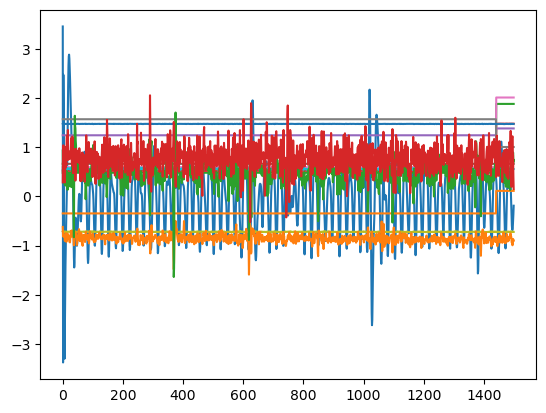

In [11]:
# plot the first 2 sequences
plt.plot(X[0].T)

In [12]:
labeler = ReLabeler(class_map)
new_y = labeler(y) # map to more descriptive labels

X.shape, new_y.shape

((4651, 14, 1500), (4651,))

In [13]:
label_counts = collections.Counter(new_y)
print('Counts by label:', dict(label_counts))
print(f'Naive Accuracy: {100*max(label_counts.values())/sum(label_counts.values()):0.2f}%')

Counts by label: {'WK': 1469, 'SL': 3182}
Naive Accuracy: 68.42%


## Dataloaders

In [14]:
# metrics = [accuracy, Precision(), Recall(), F1Score()]

# model = build_ts_model(InceptionTimePlus, dls=dls, **{'fc_dropout' : 0.5})
# # model = build_ts_model(InceptionTimePlus, dls=dls)

# learn = ts_learner(dls, model, metrics=metrics, cbs=ShowGraph())

In [15]:
# splits = get_splits(new_y,
#                     n_splits=15,
#                     test_size=0.0625,
#                     shuffle=False,
#                     stratify=True,
#                     check_splits=True)

In [16]:
# X_test, y_test = X[splits[0][2]], y[splits[0][2]]
# X_test.shape, y_test.shape

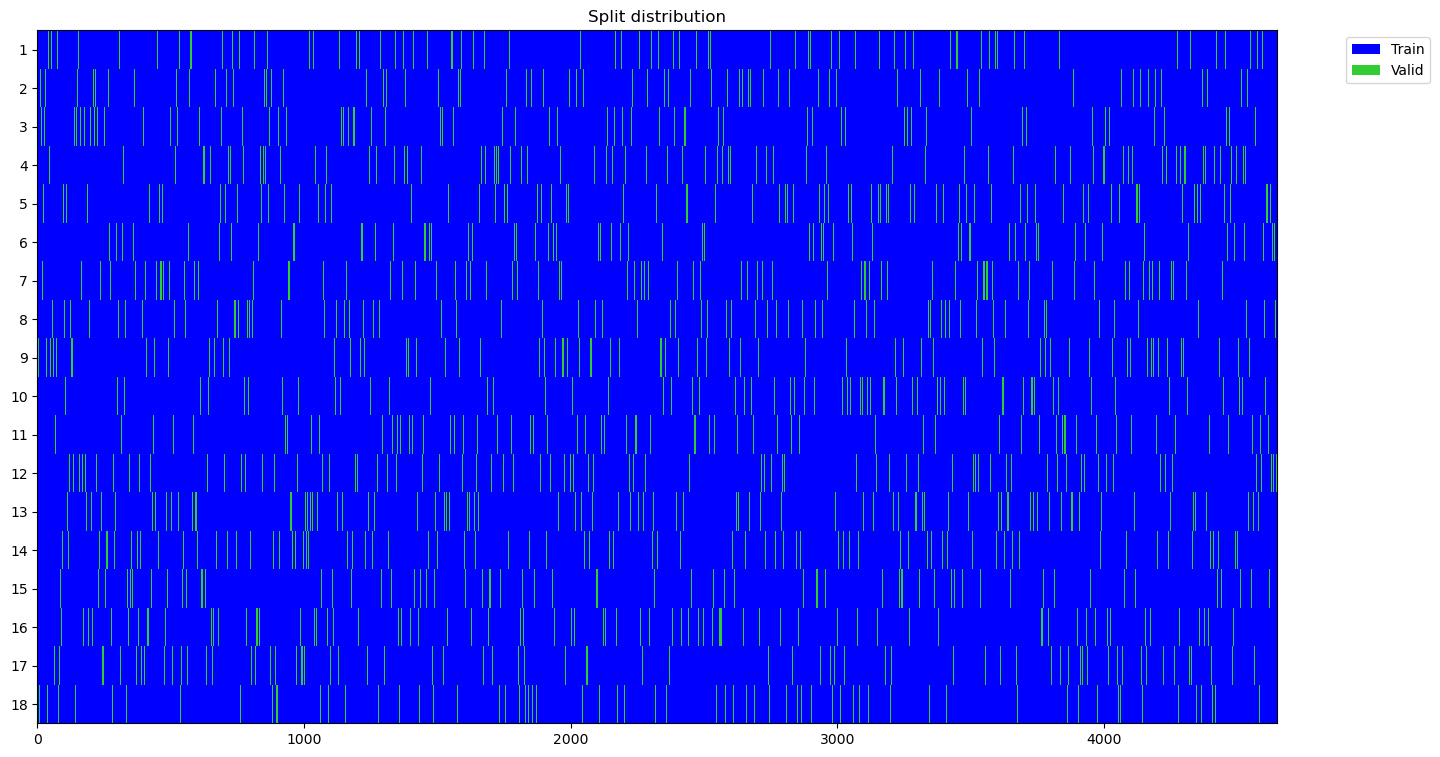

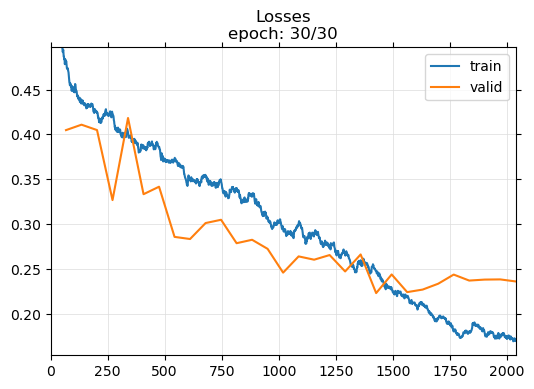

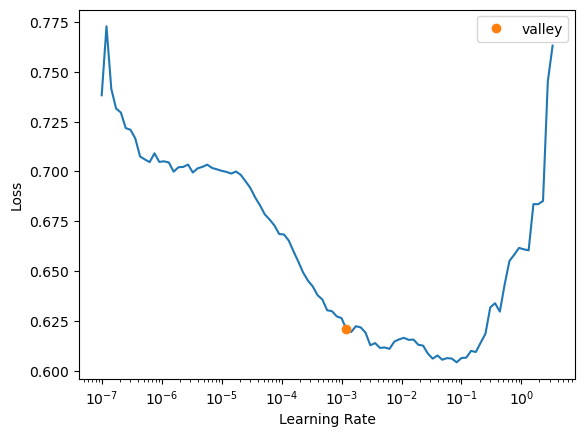

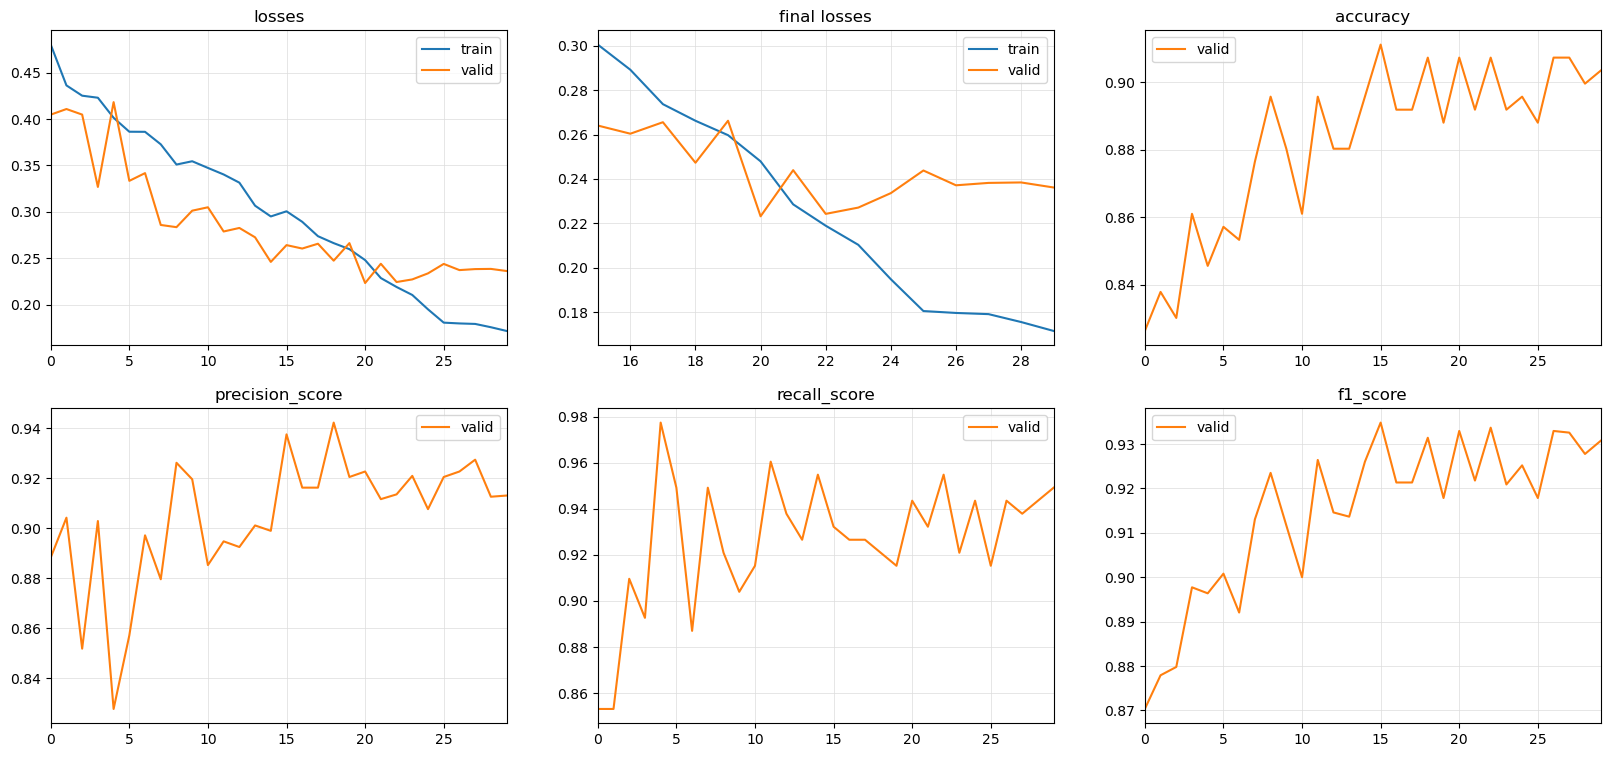

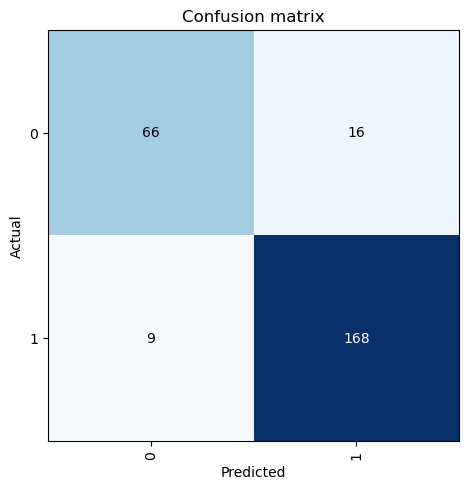

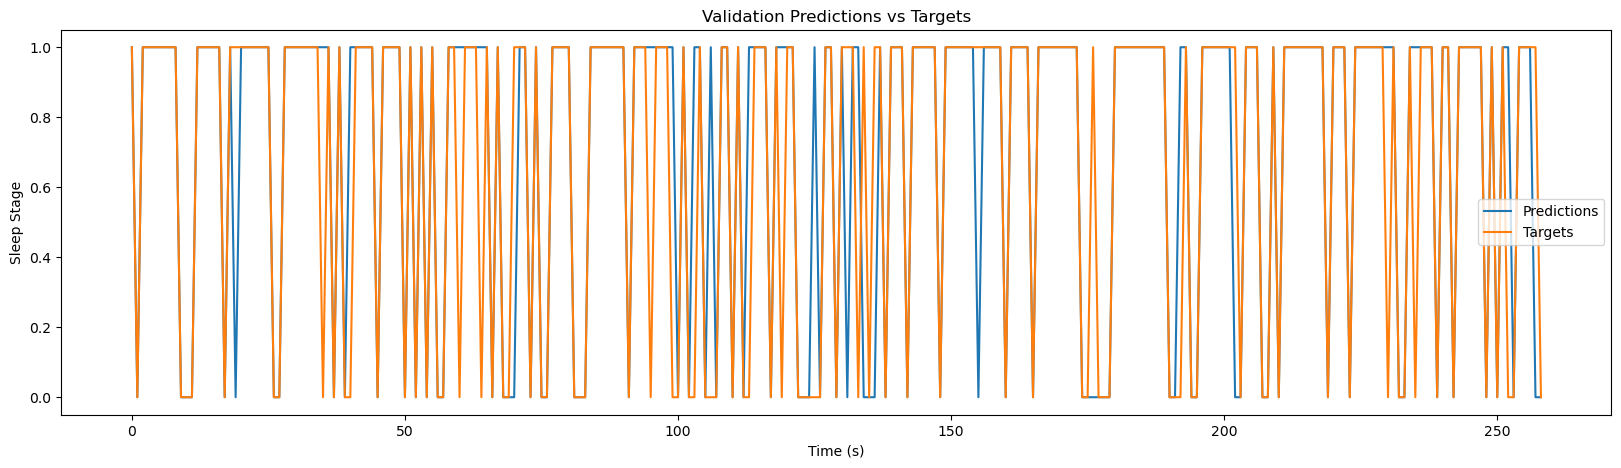

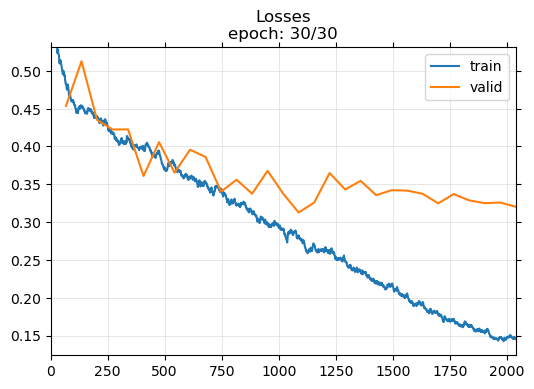

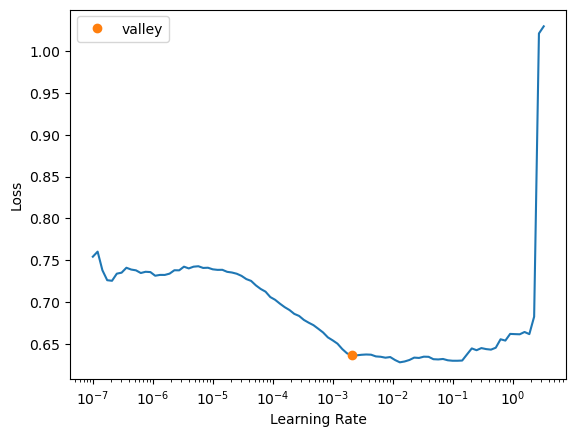

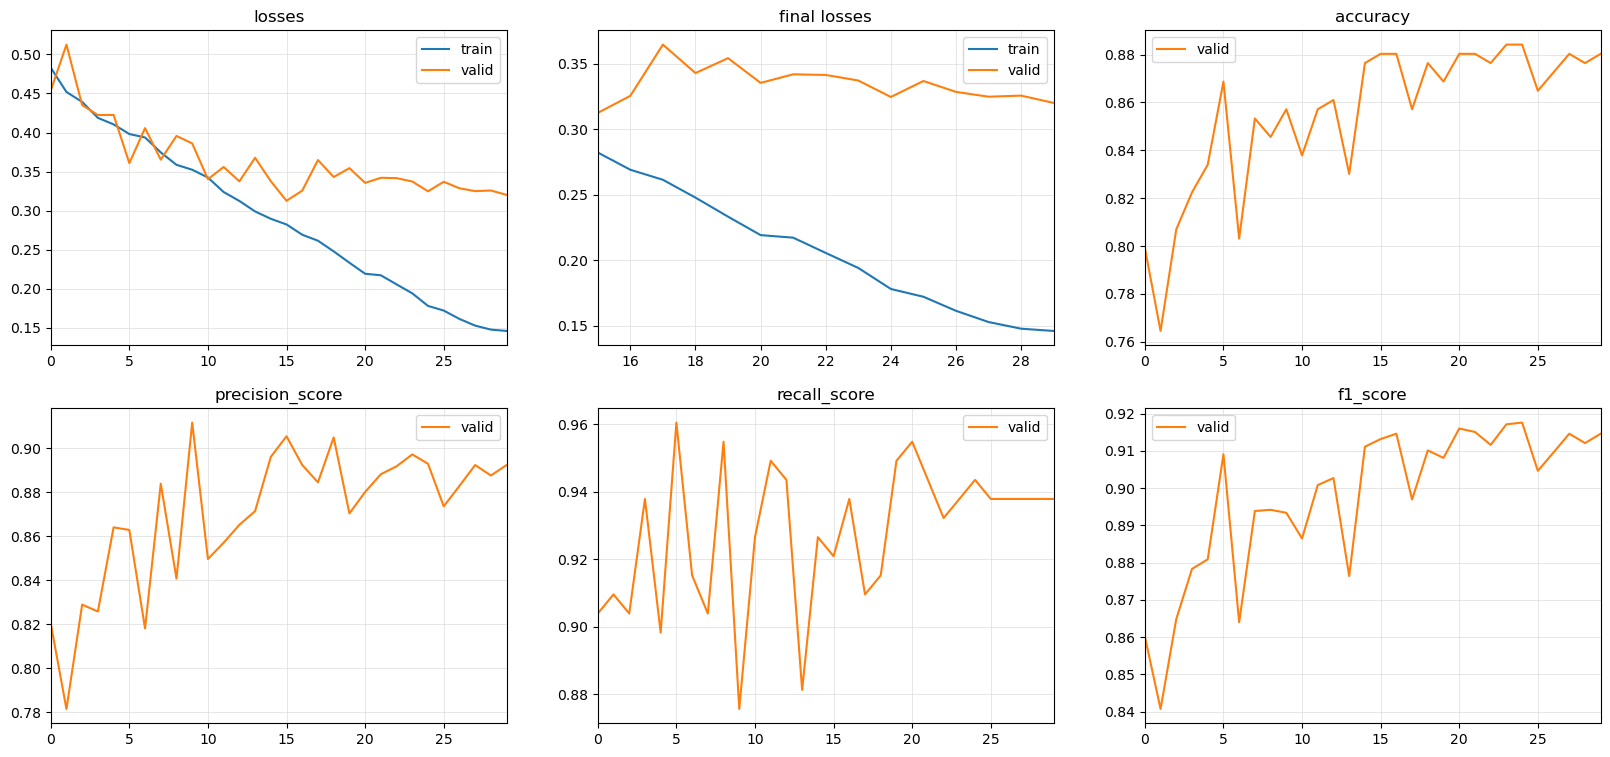

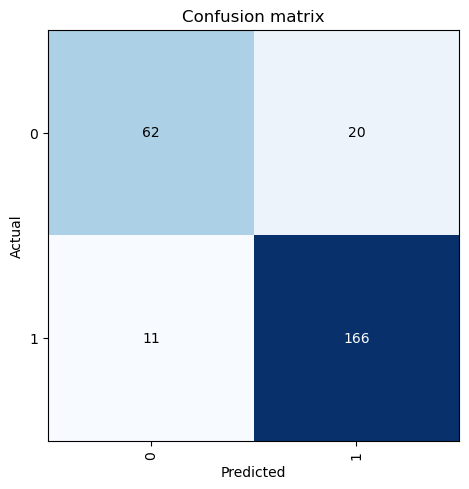

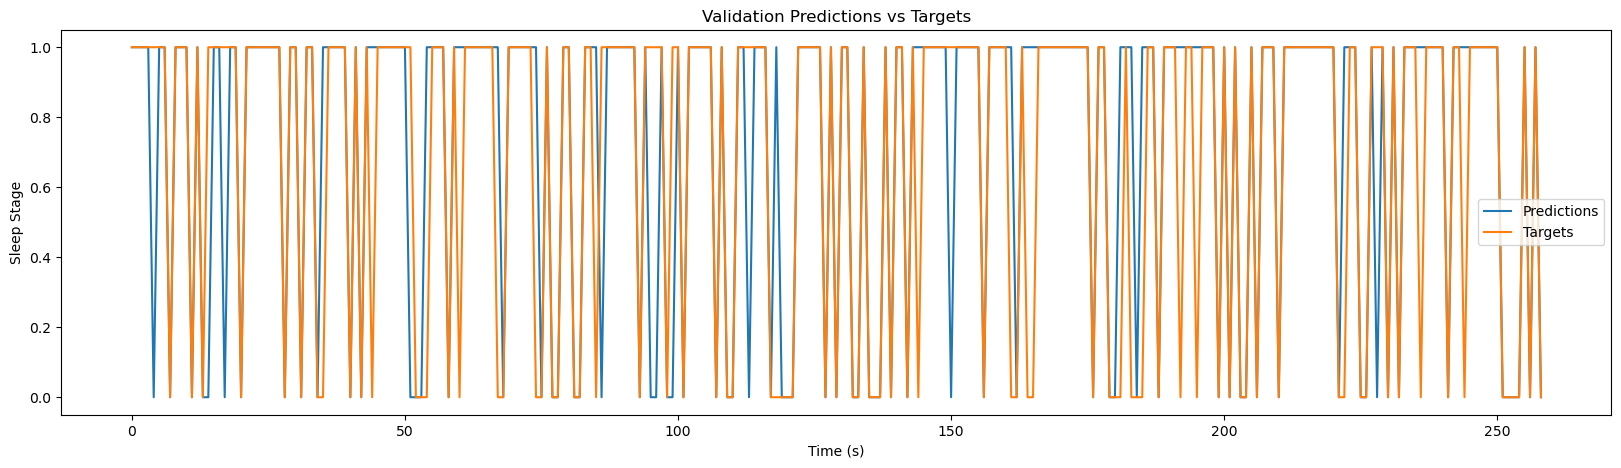

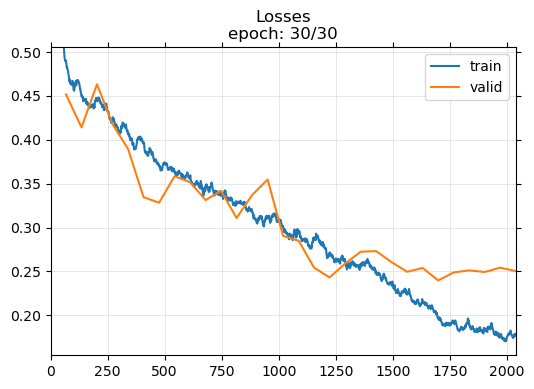

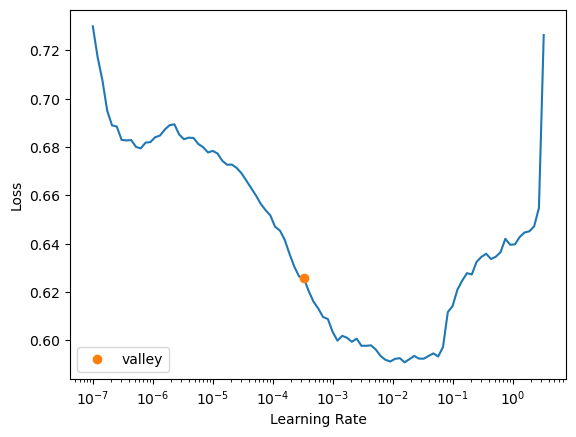

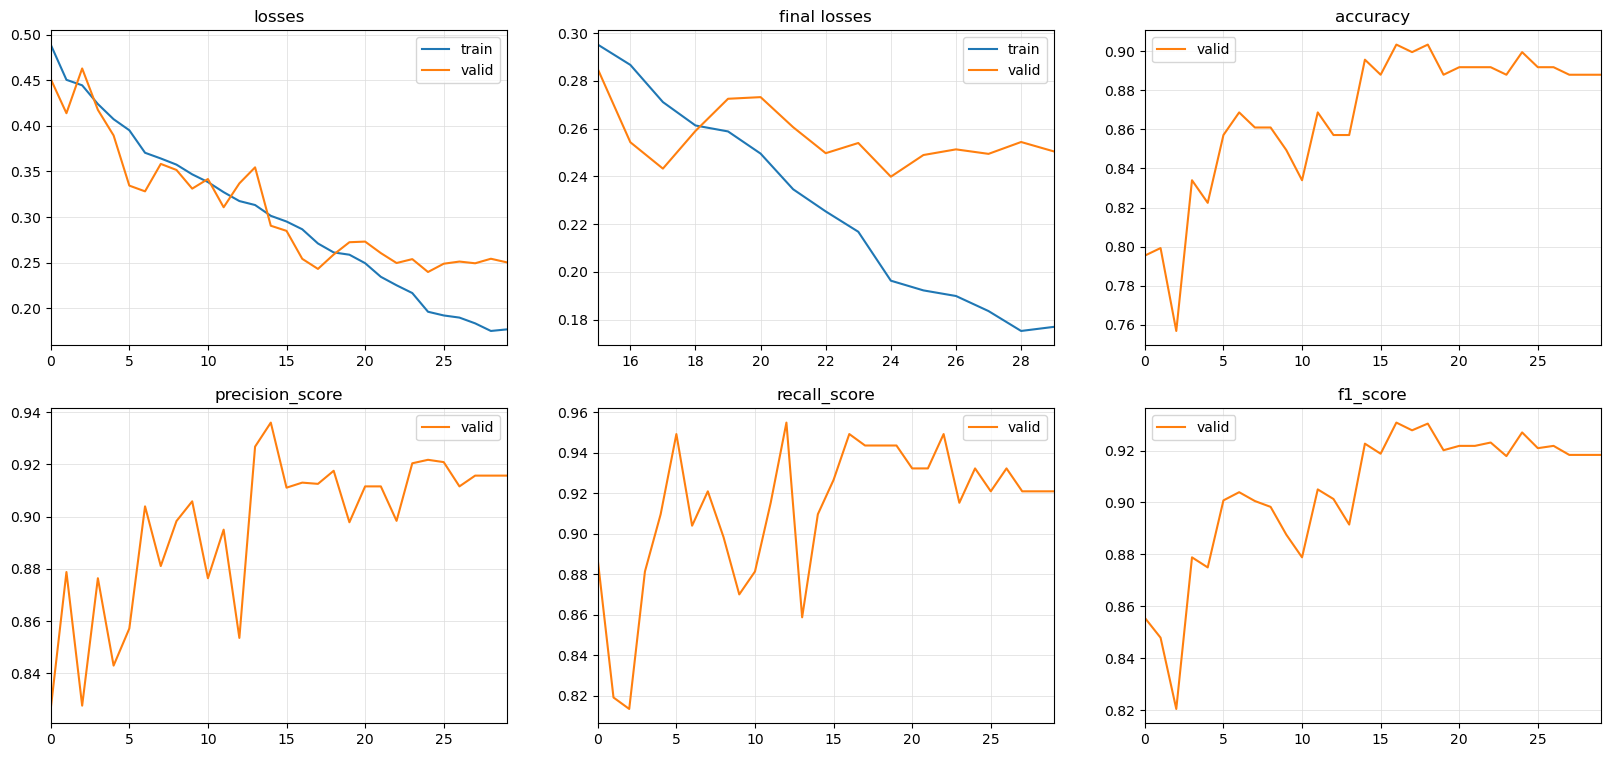

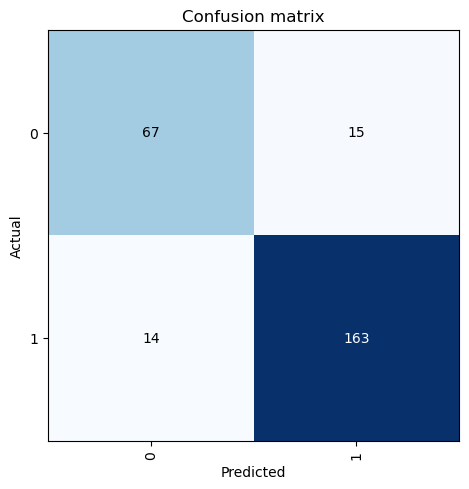

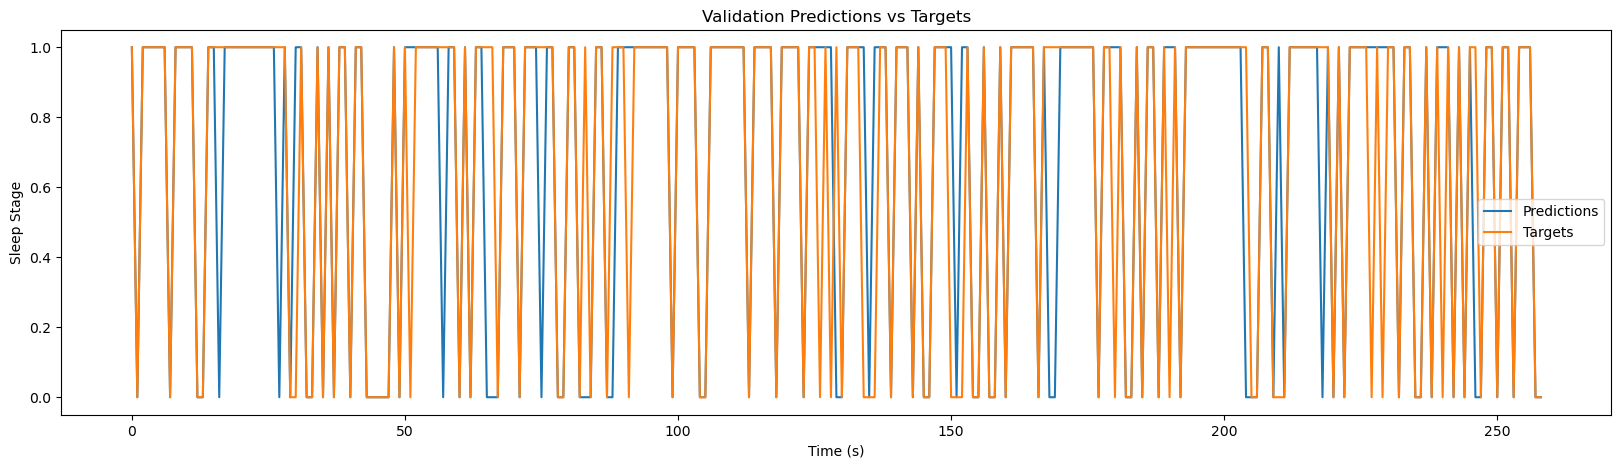

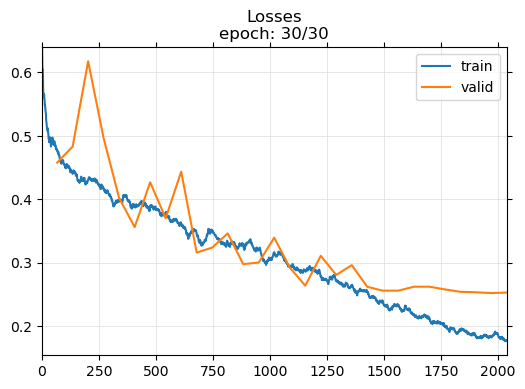

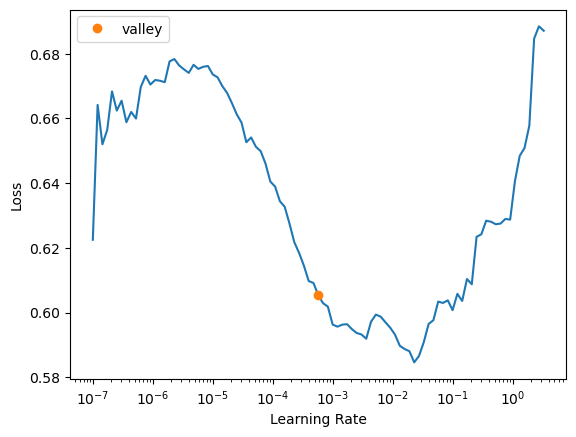

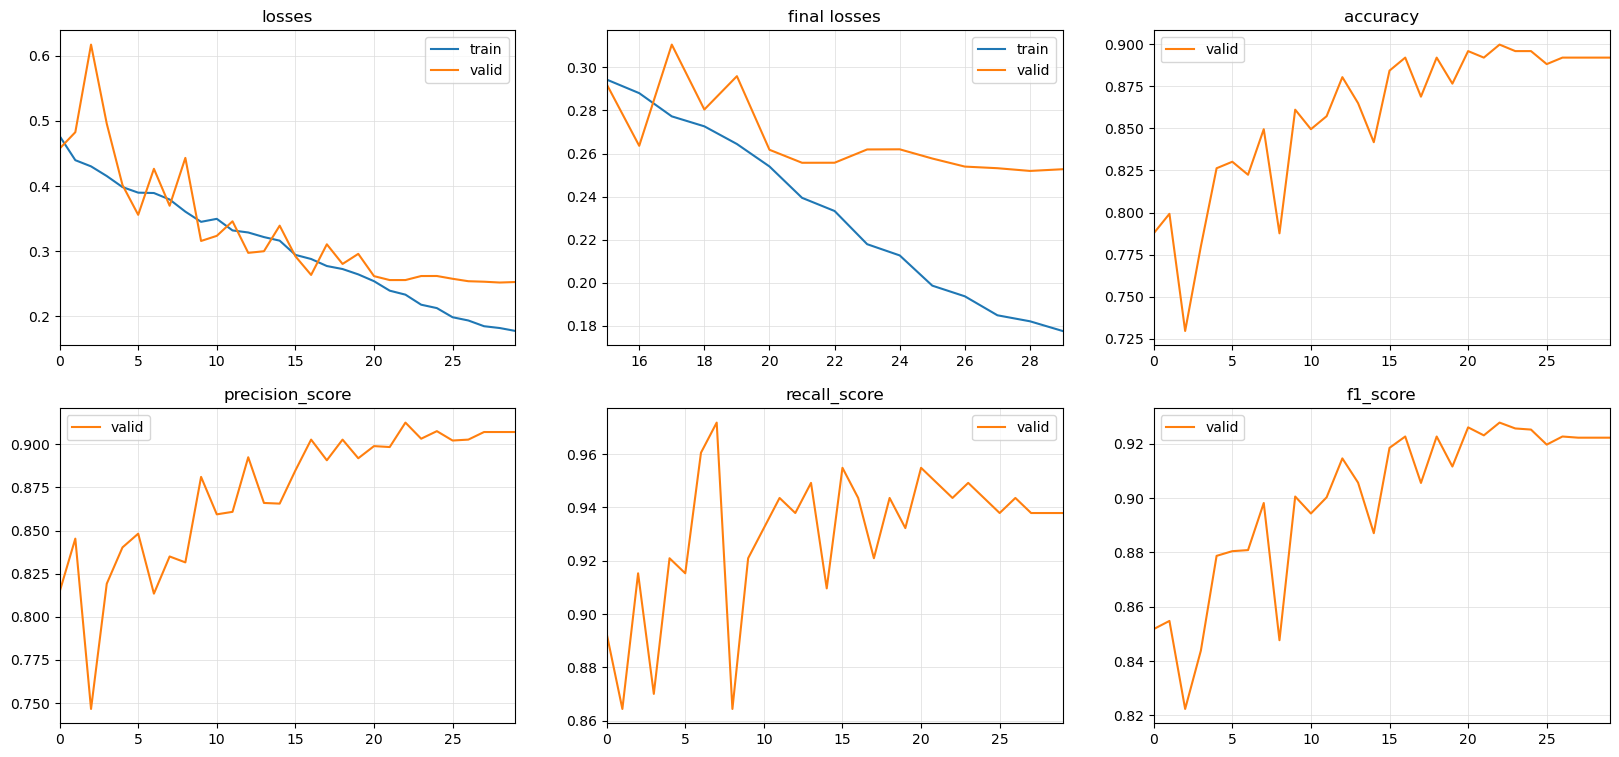

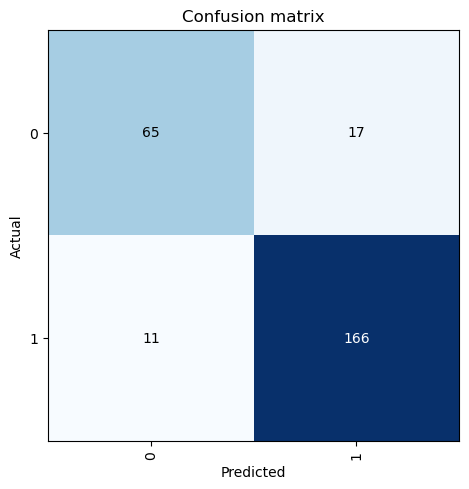

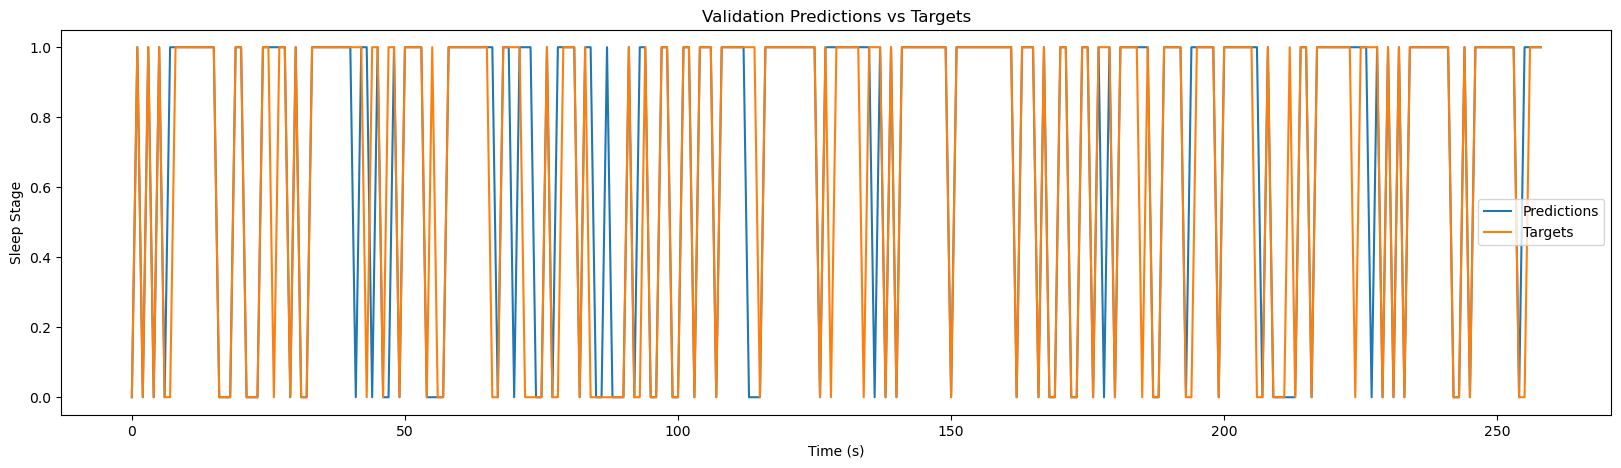

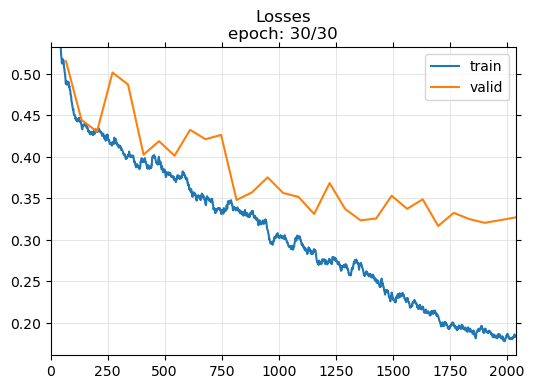

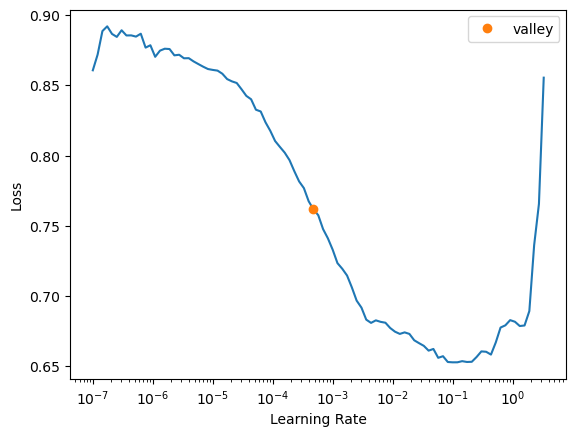

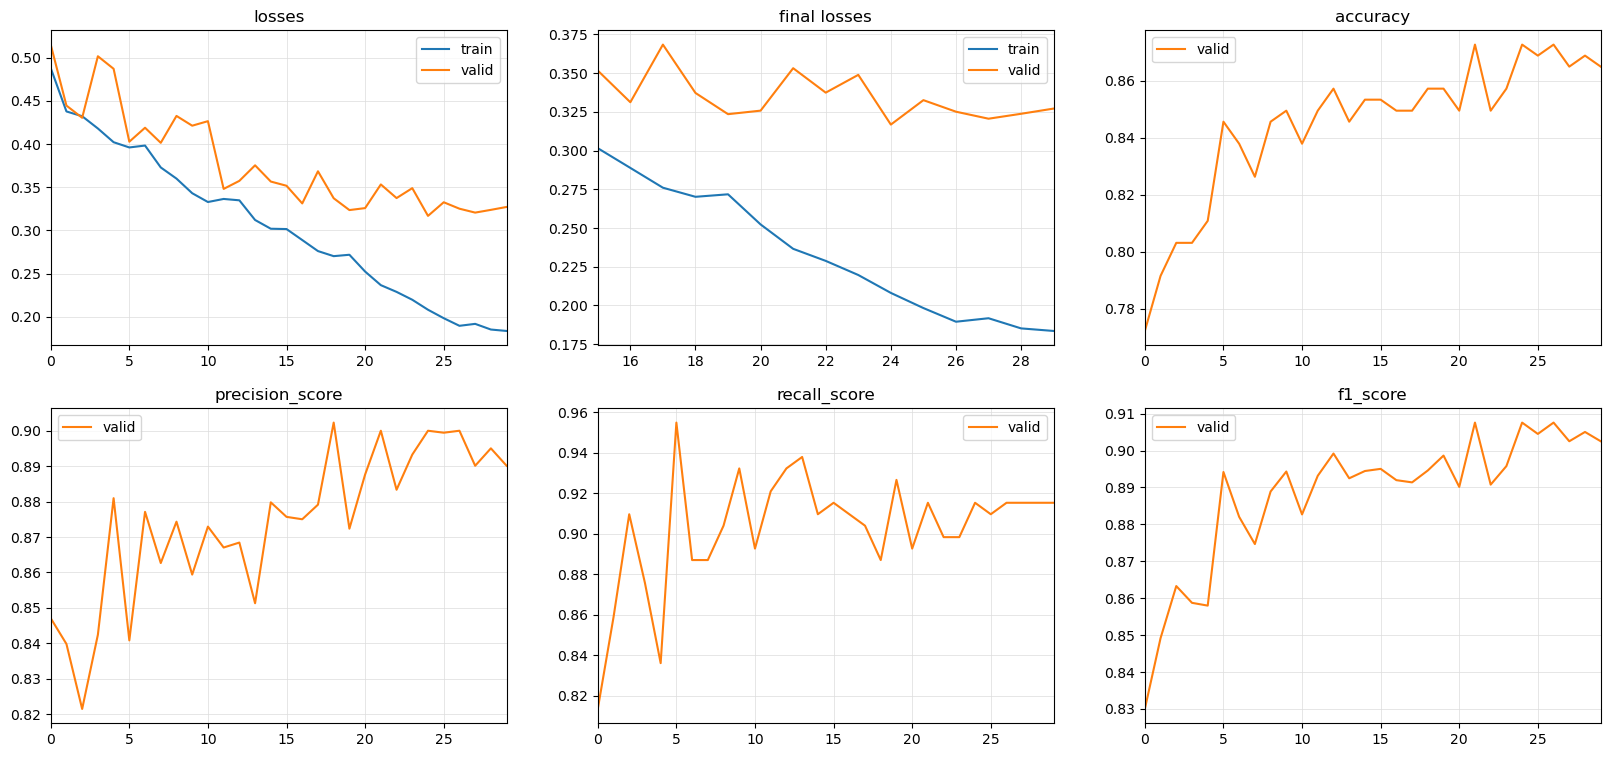

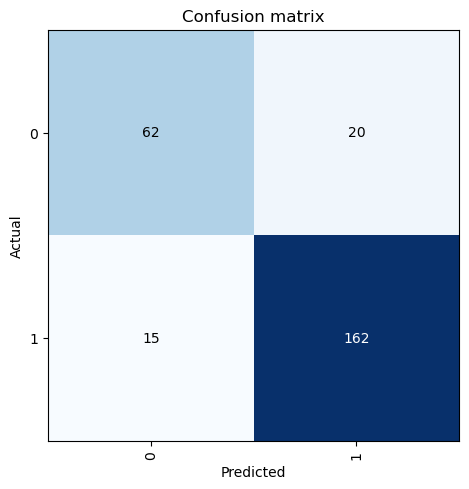

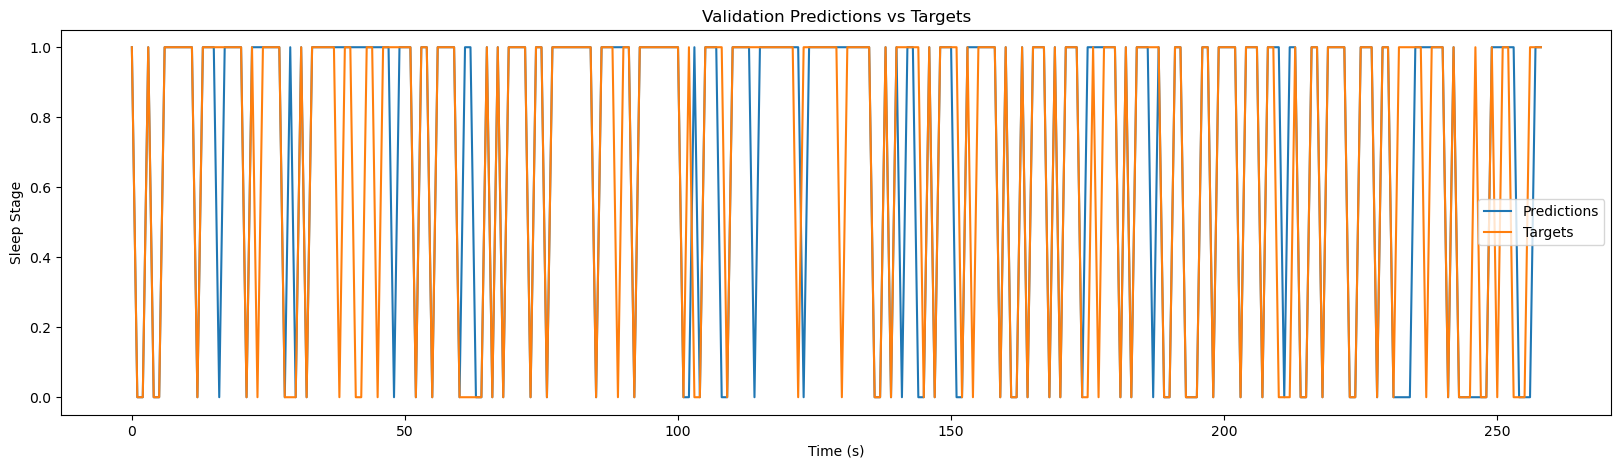

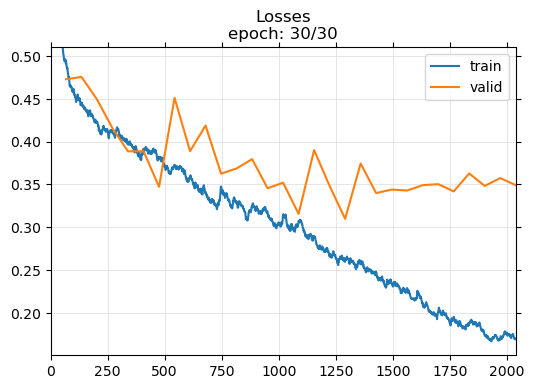

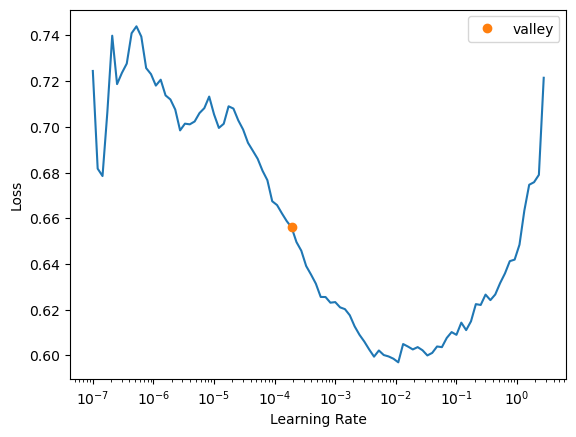

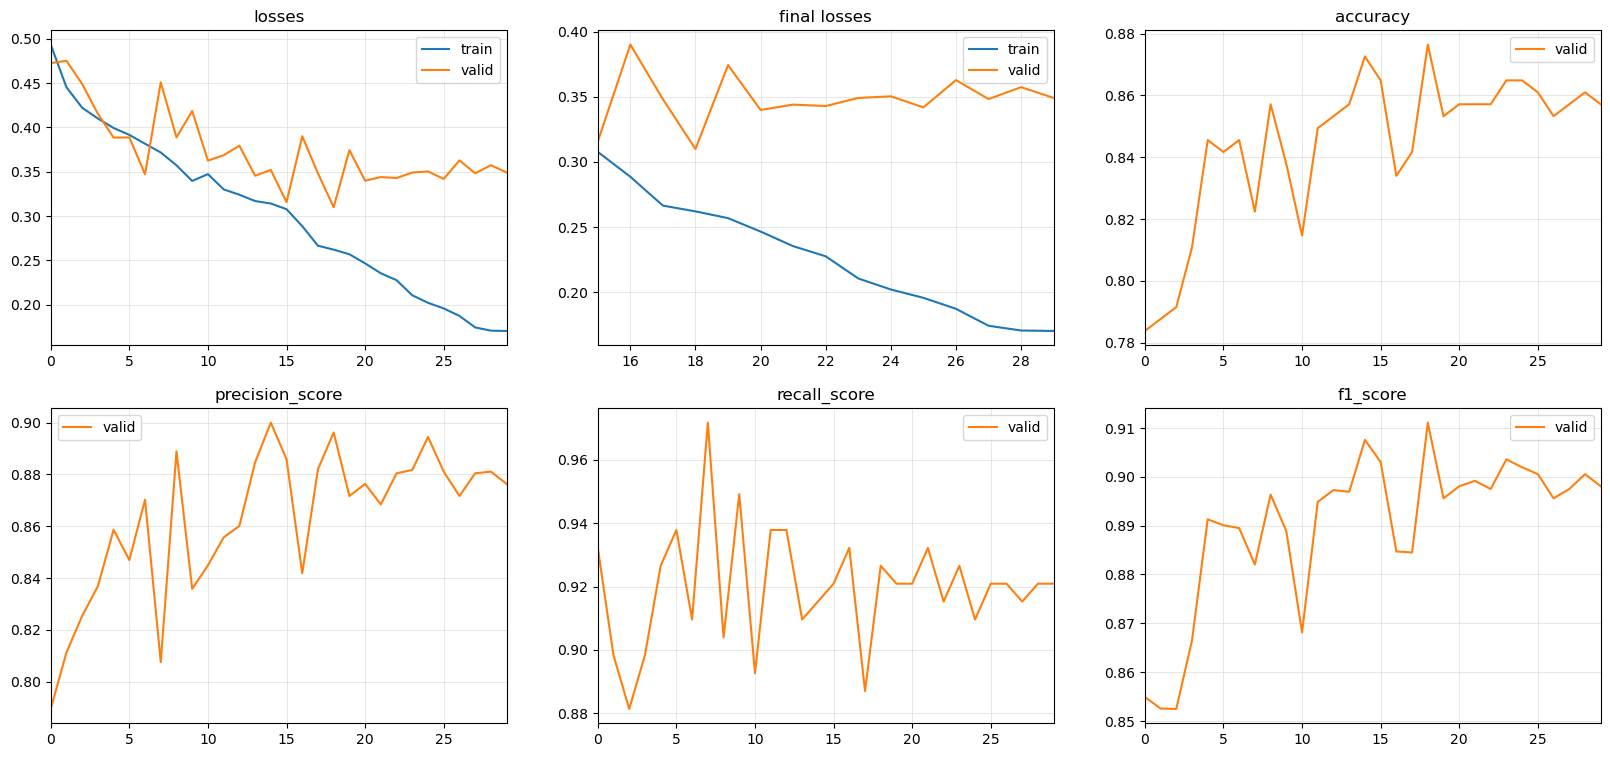

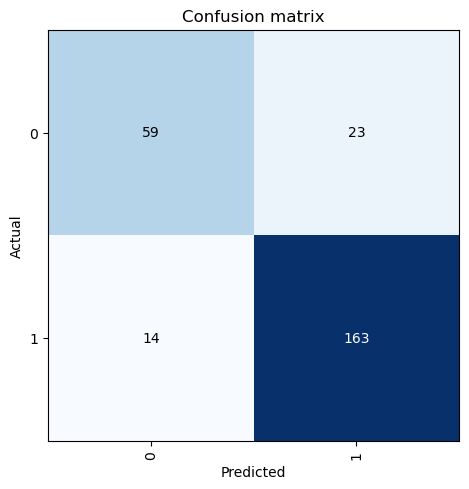

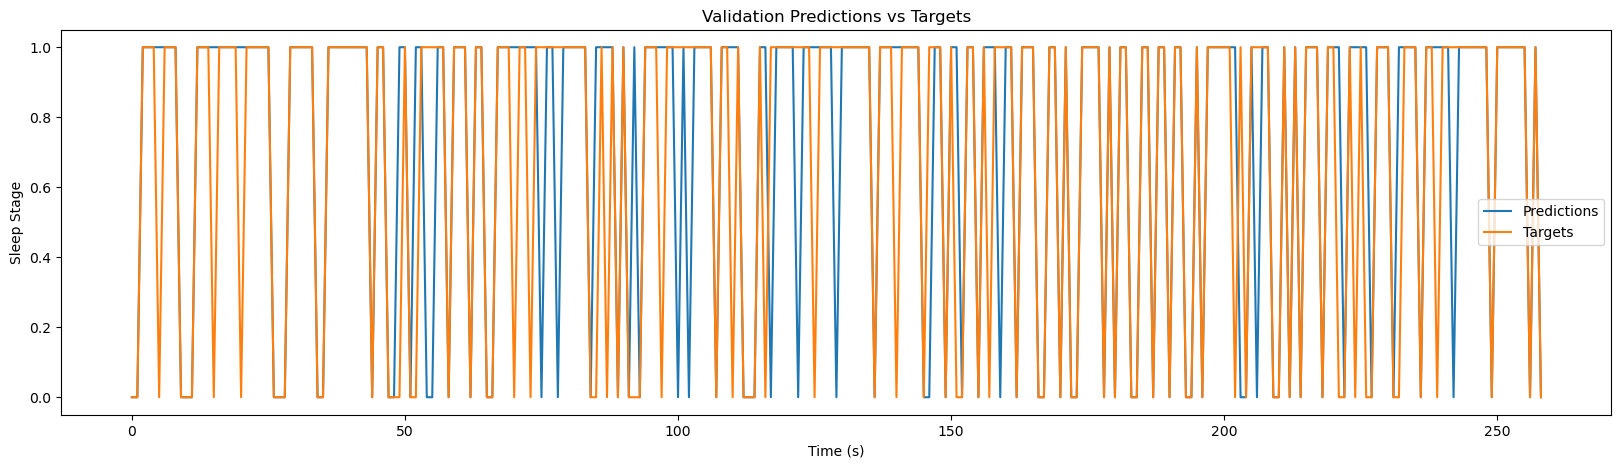

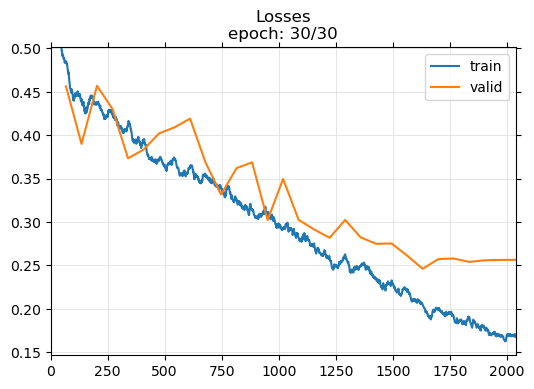

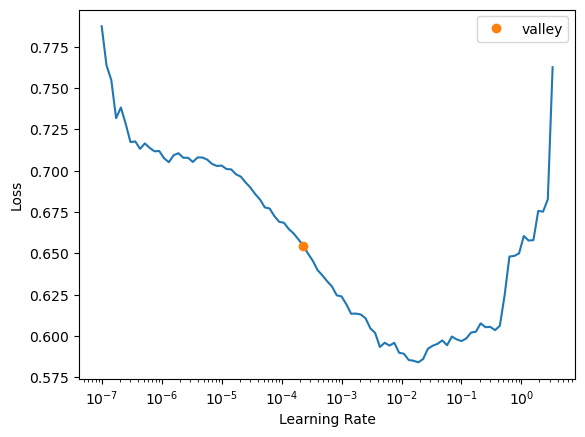

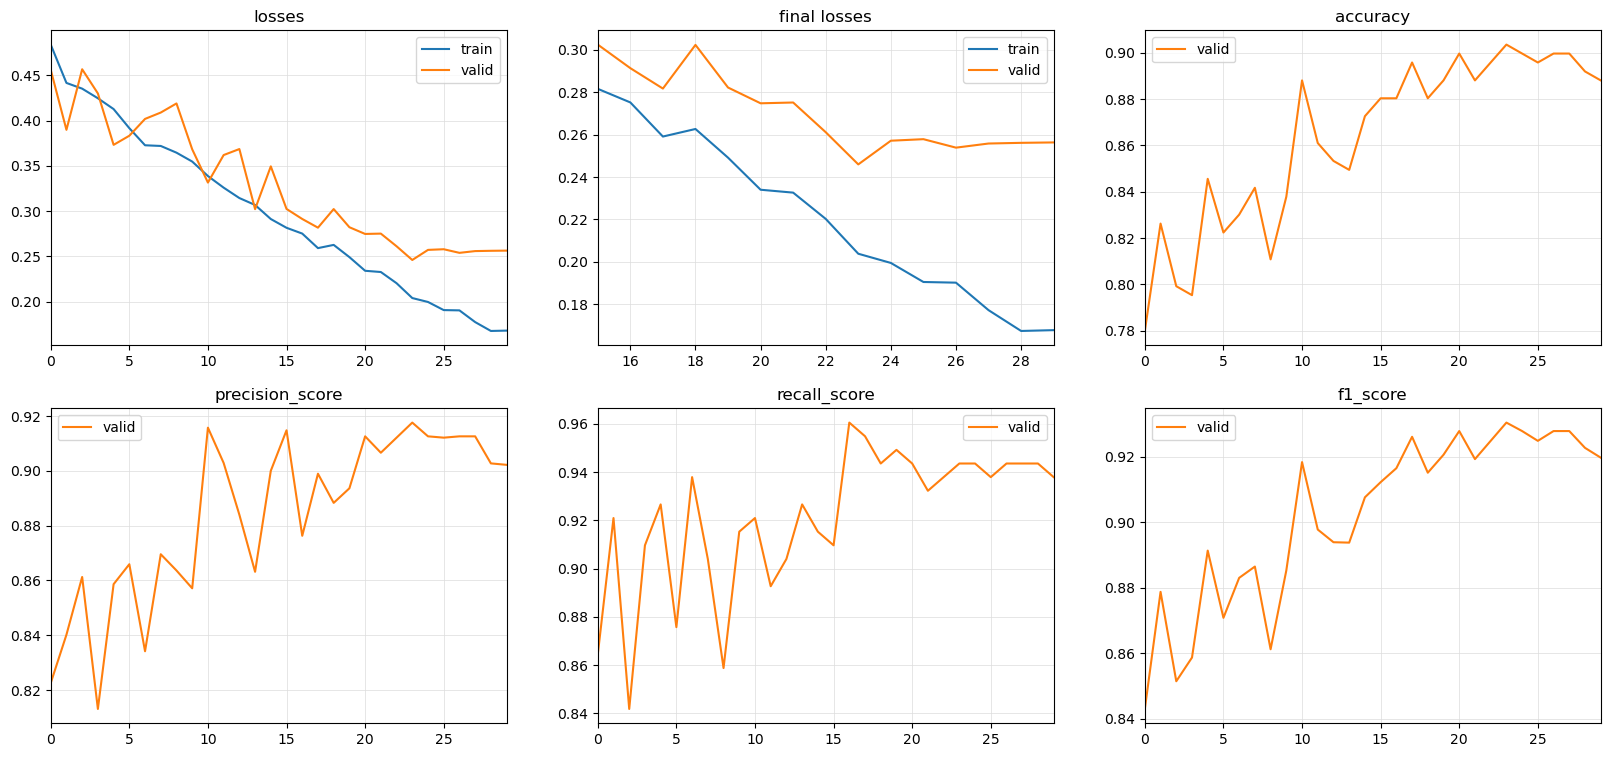

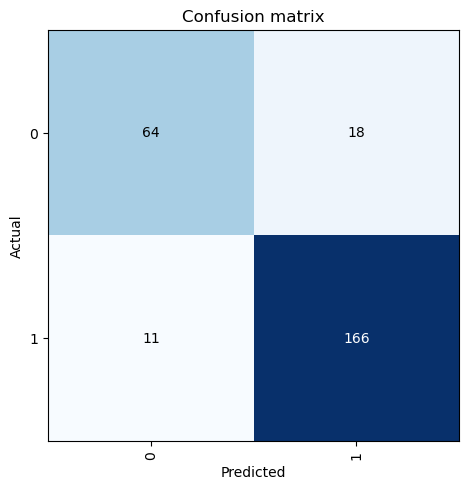

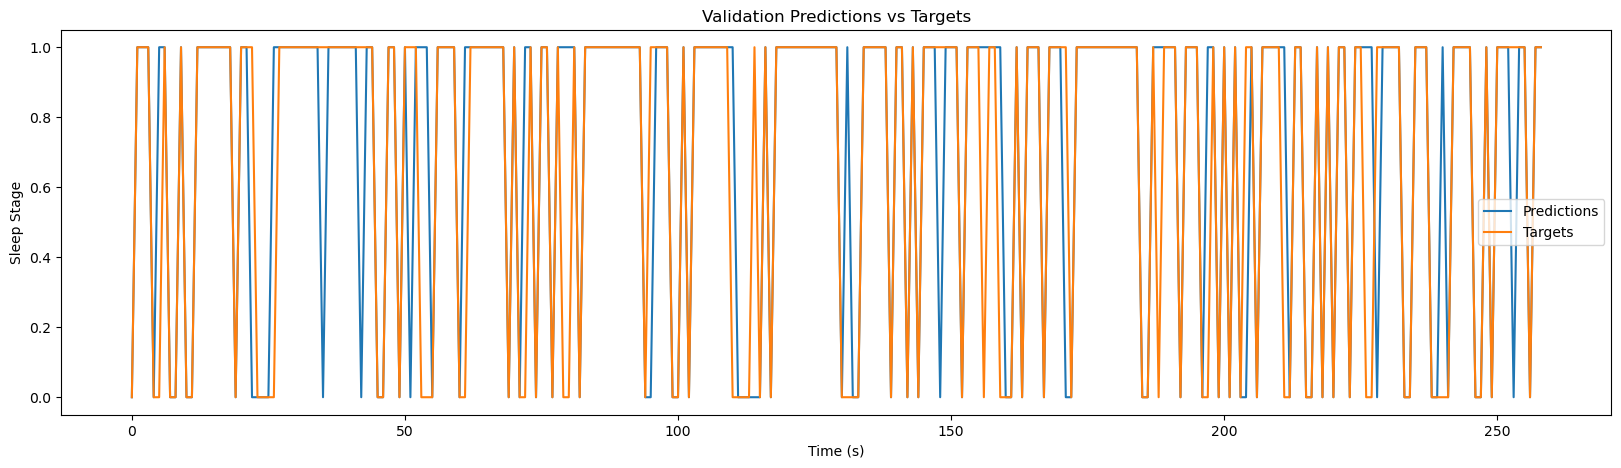

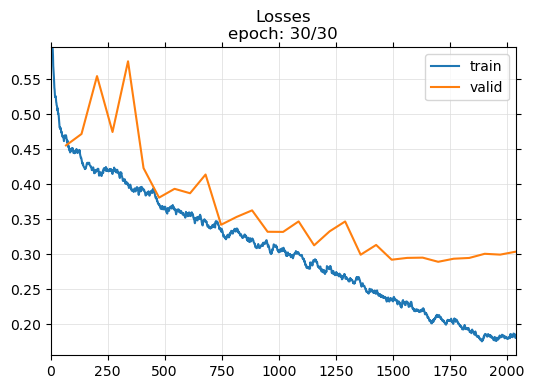

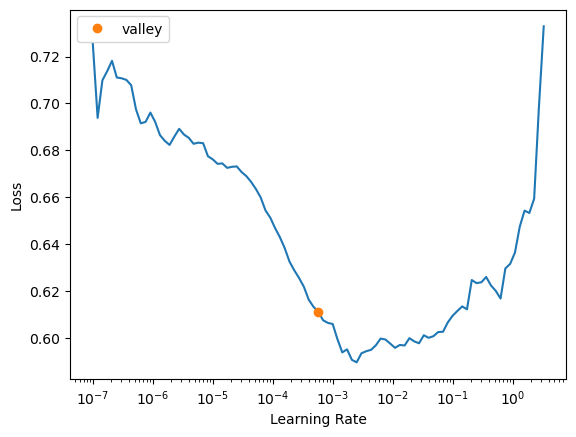

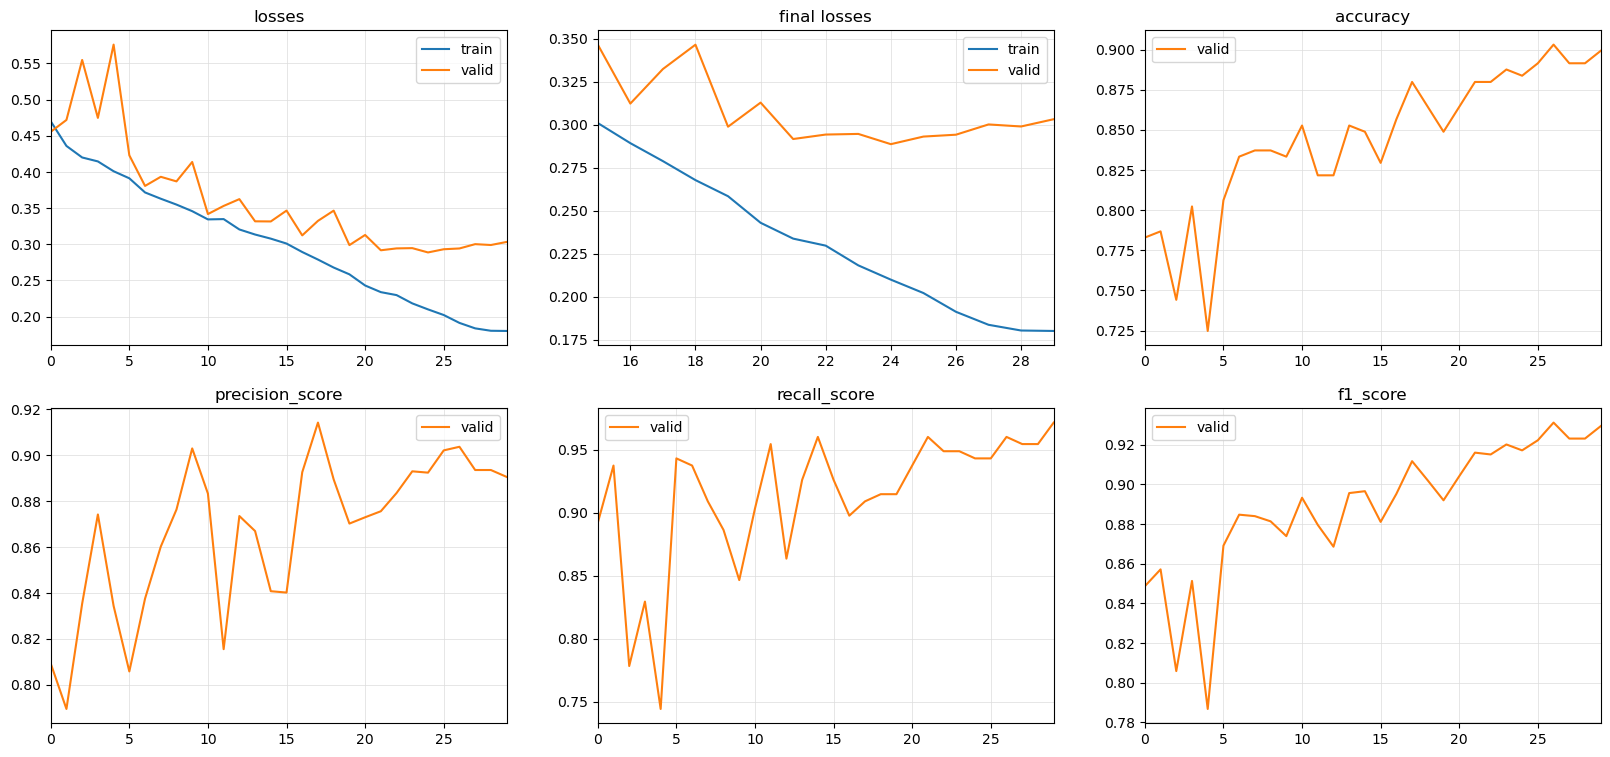

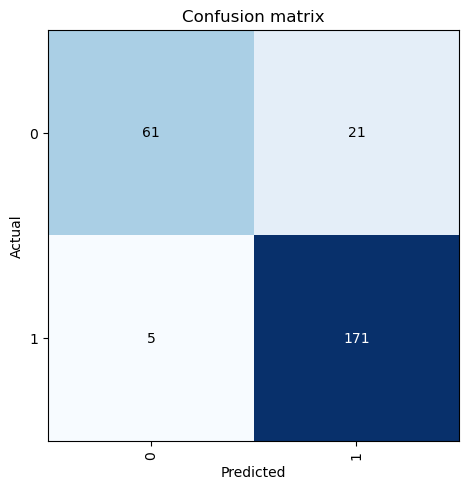

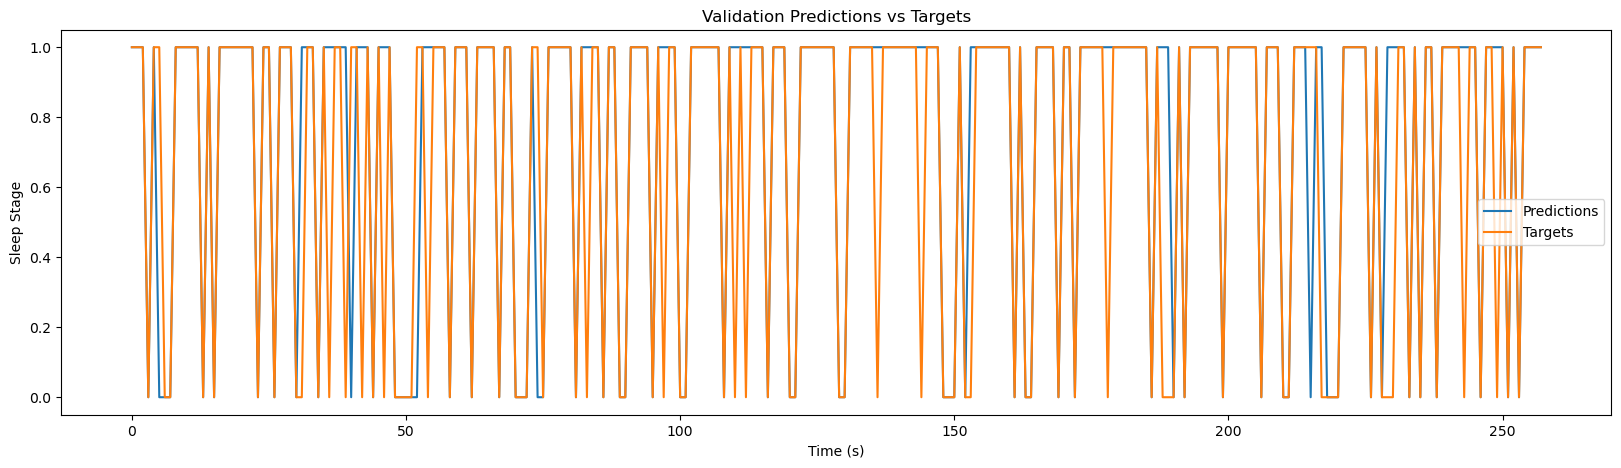

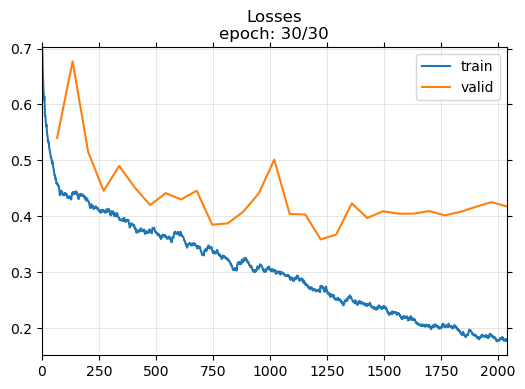

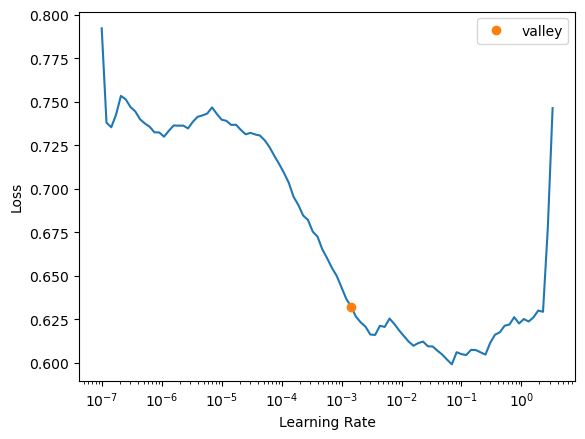

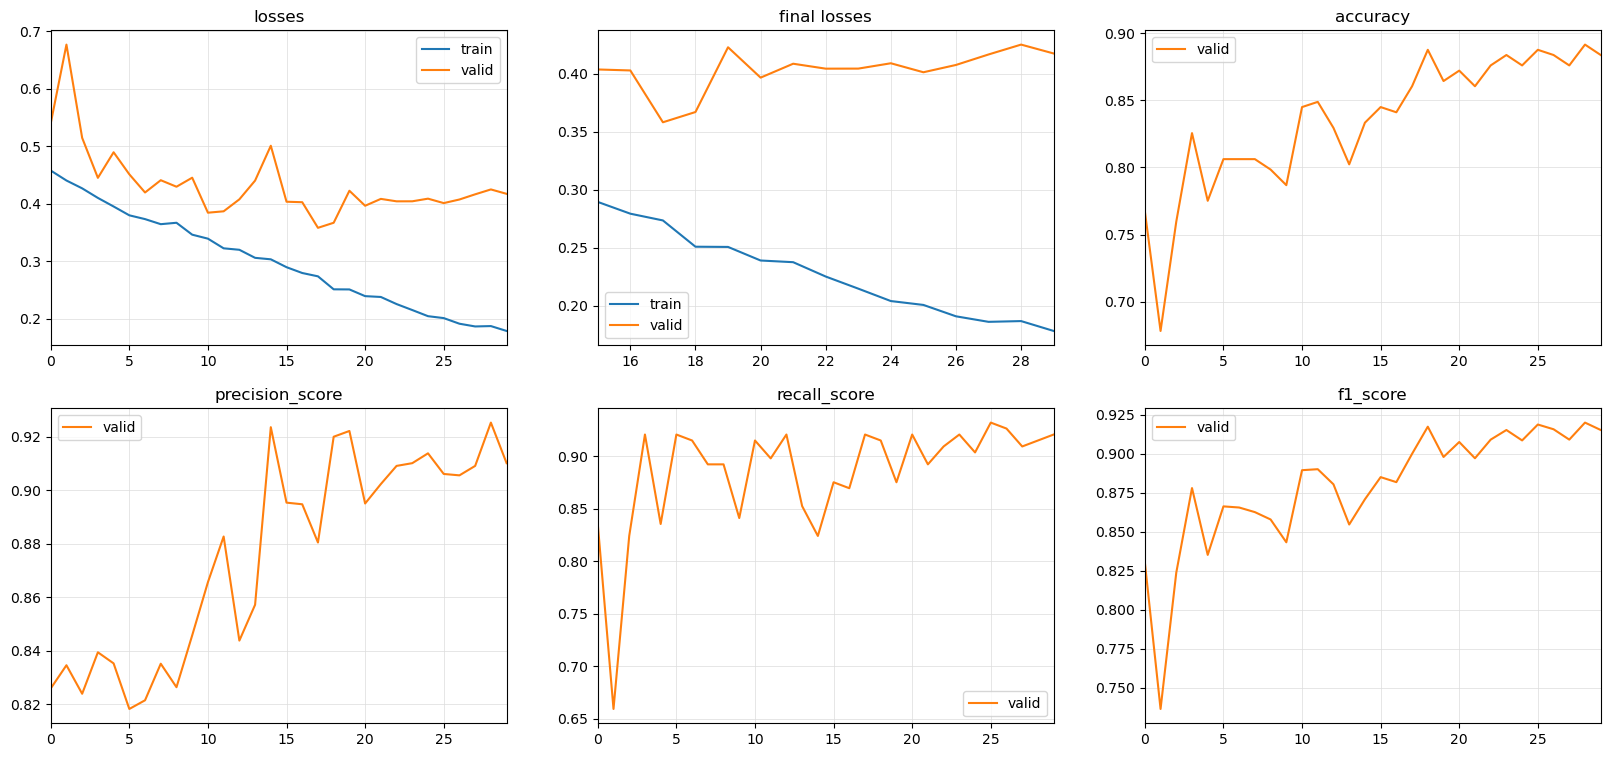

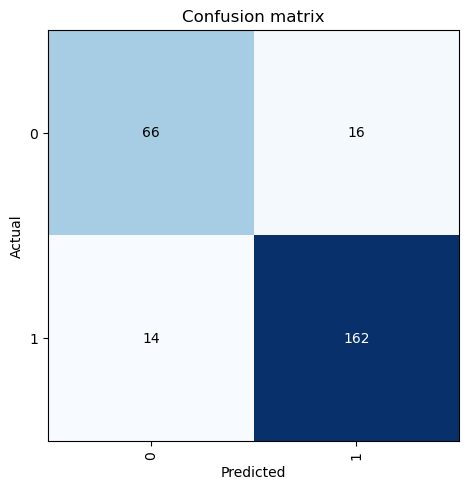

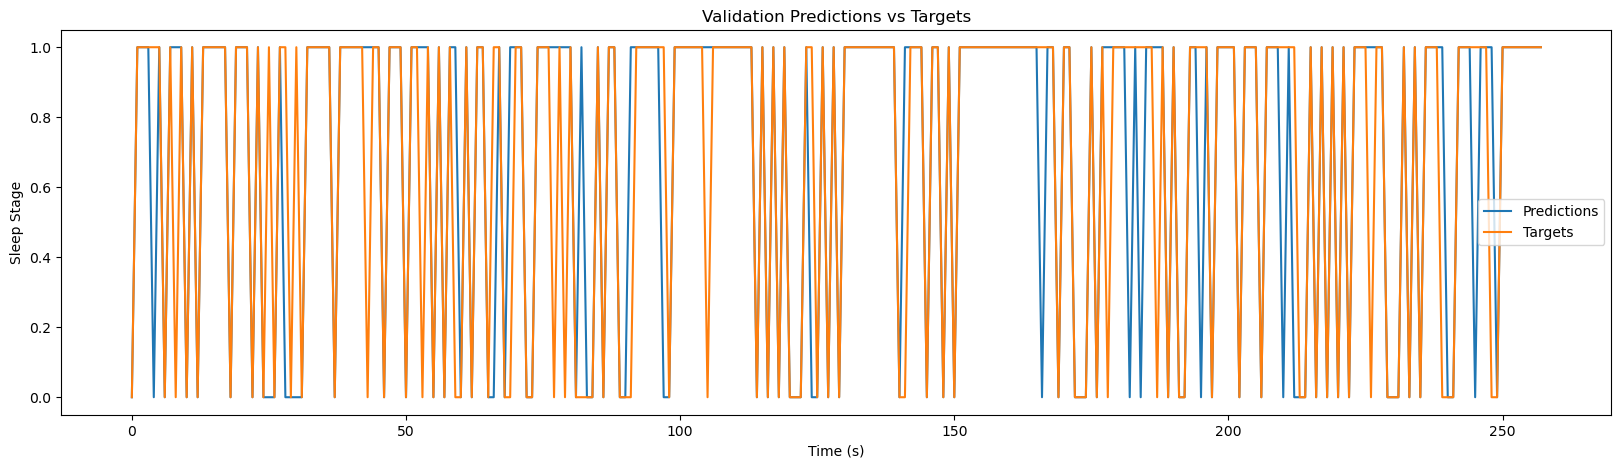

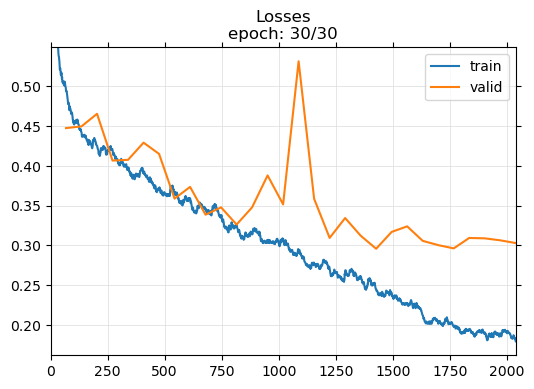

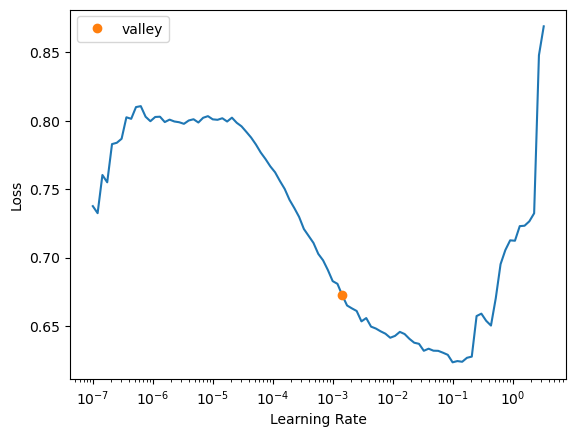

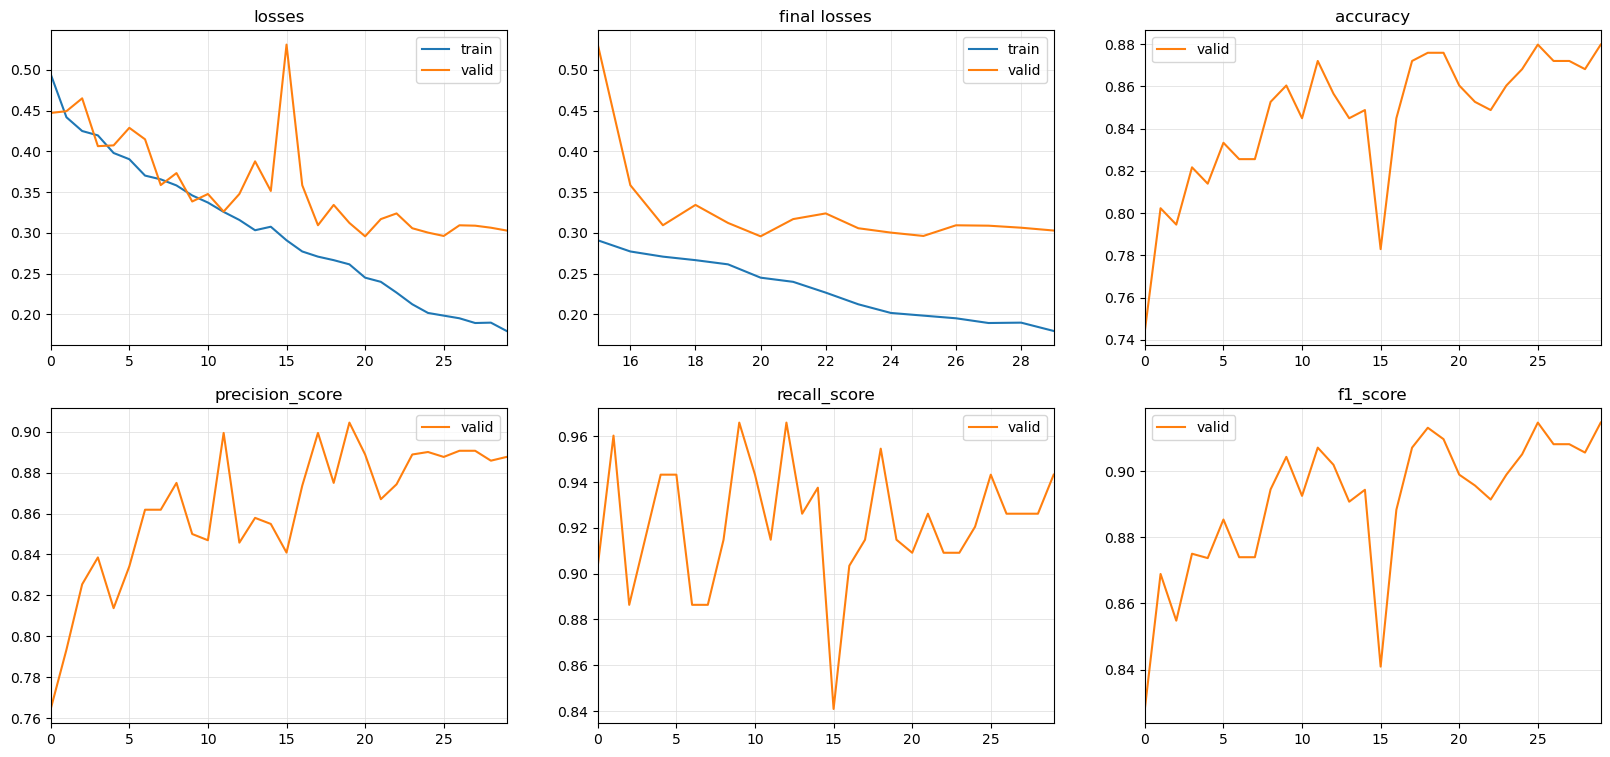

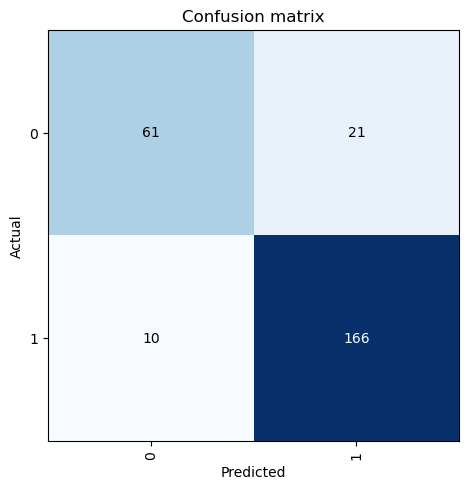

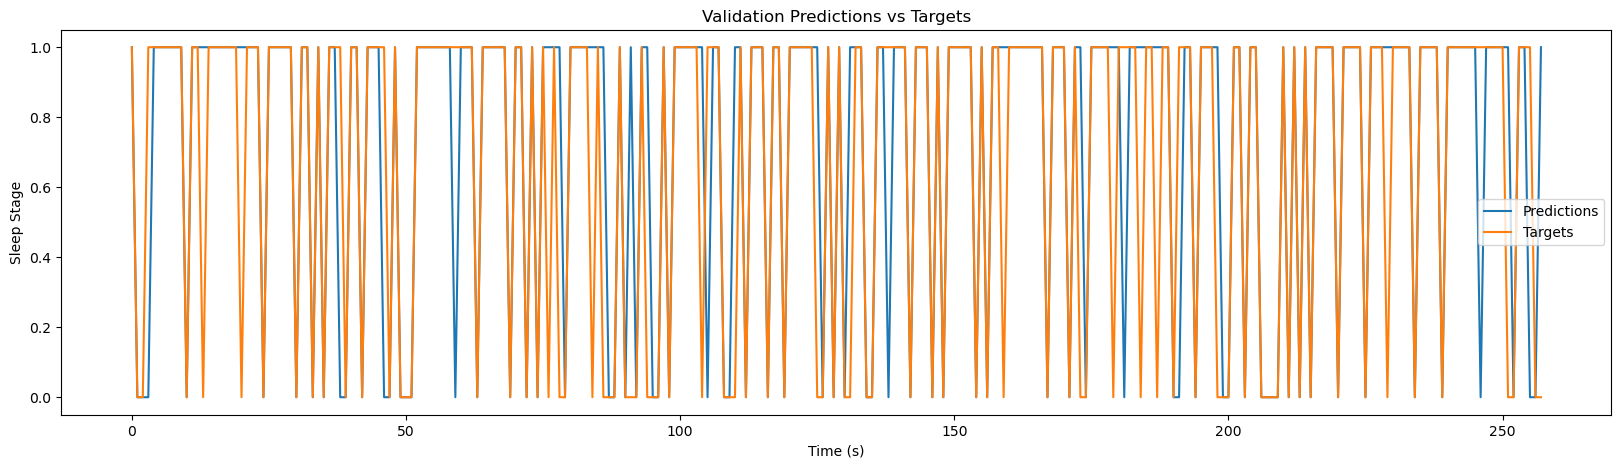

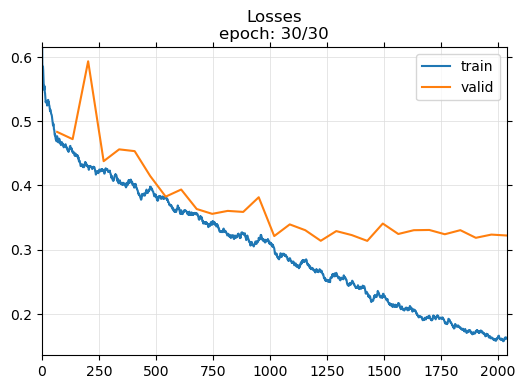

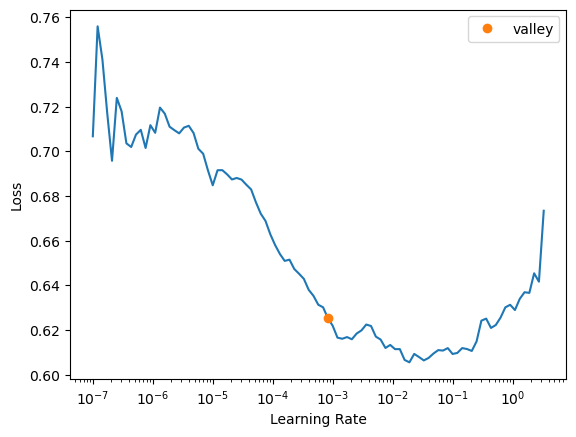

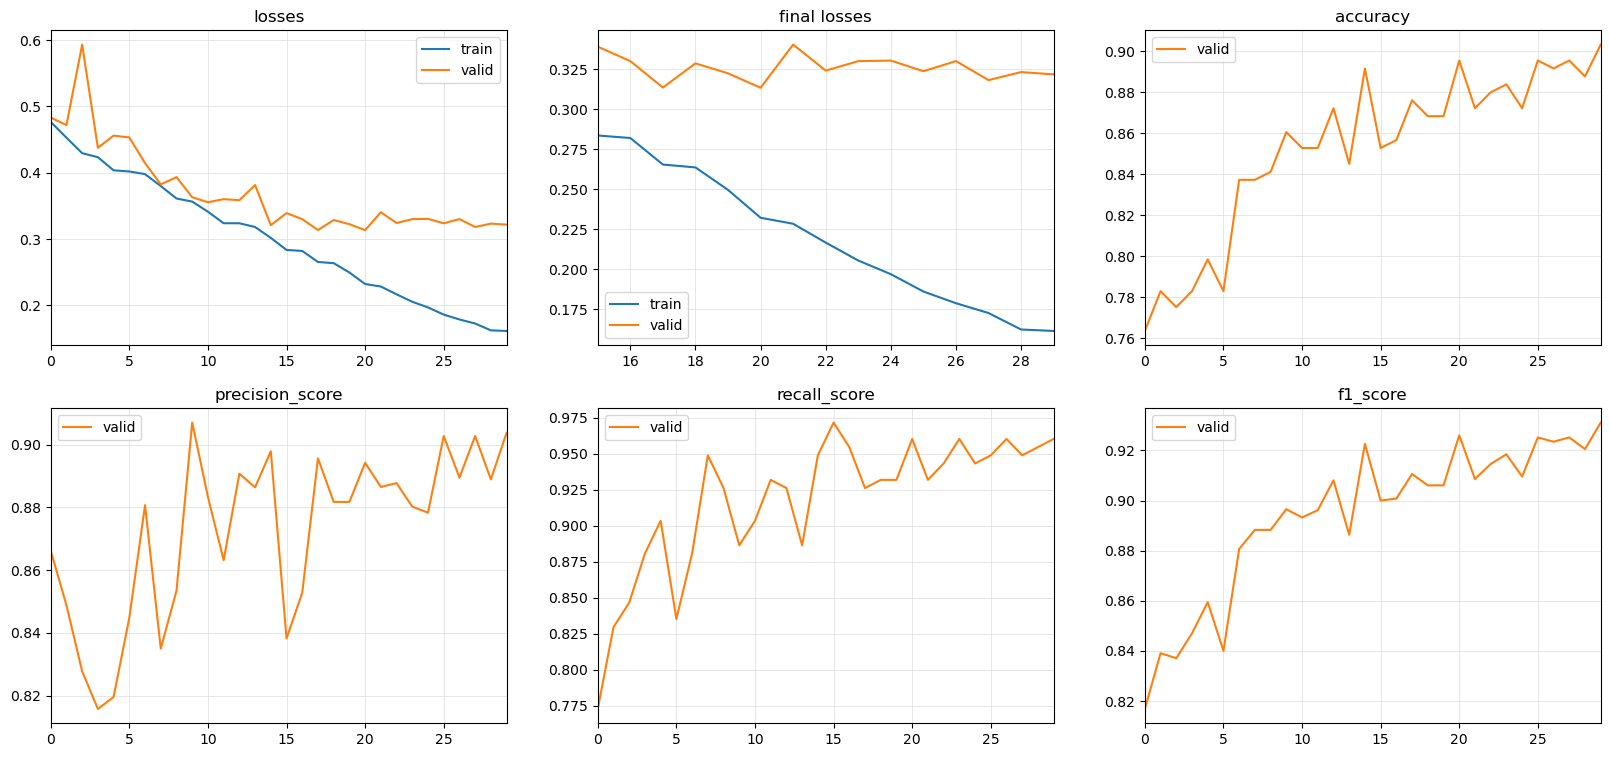

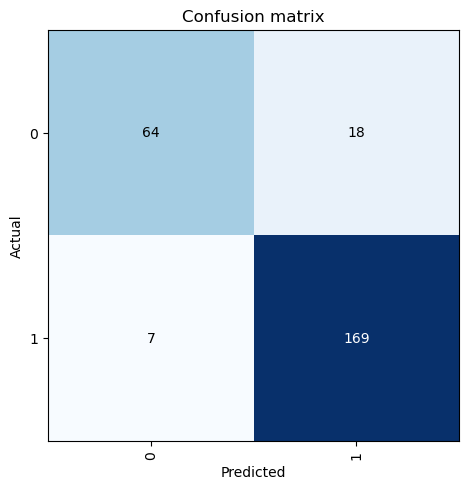

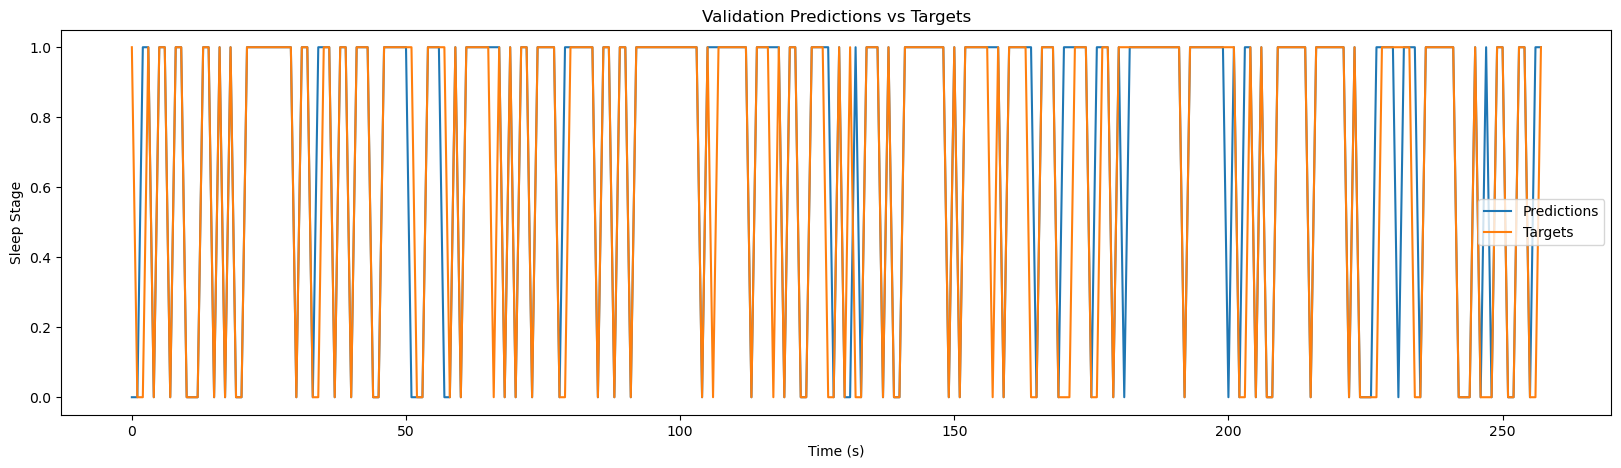

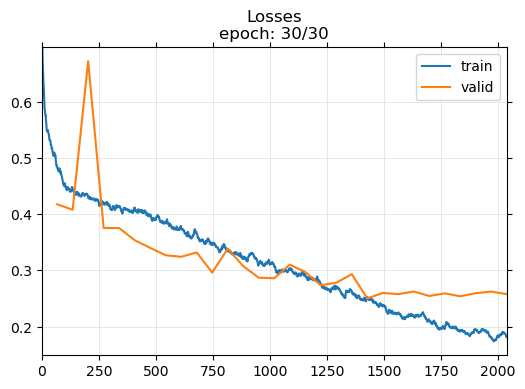

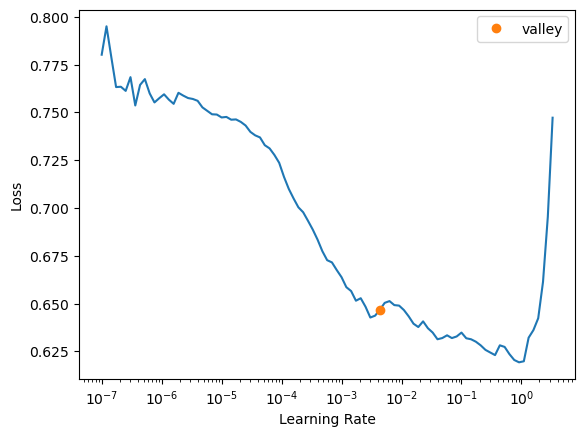

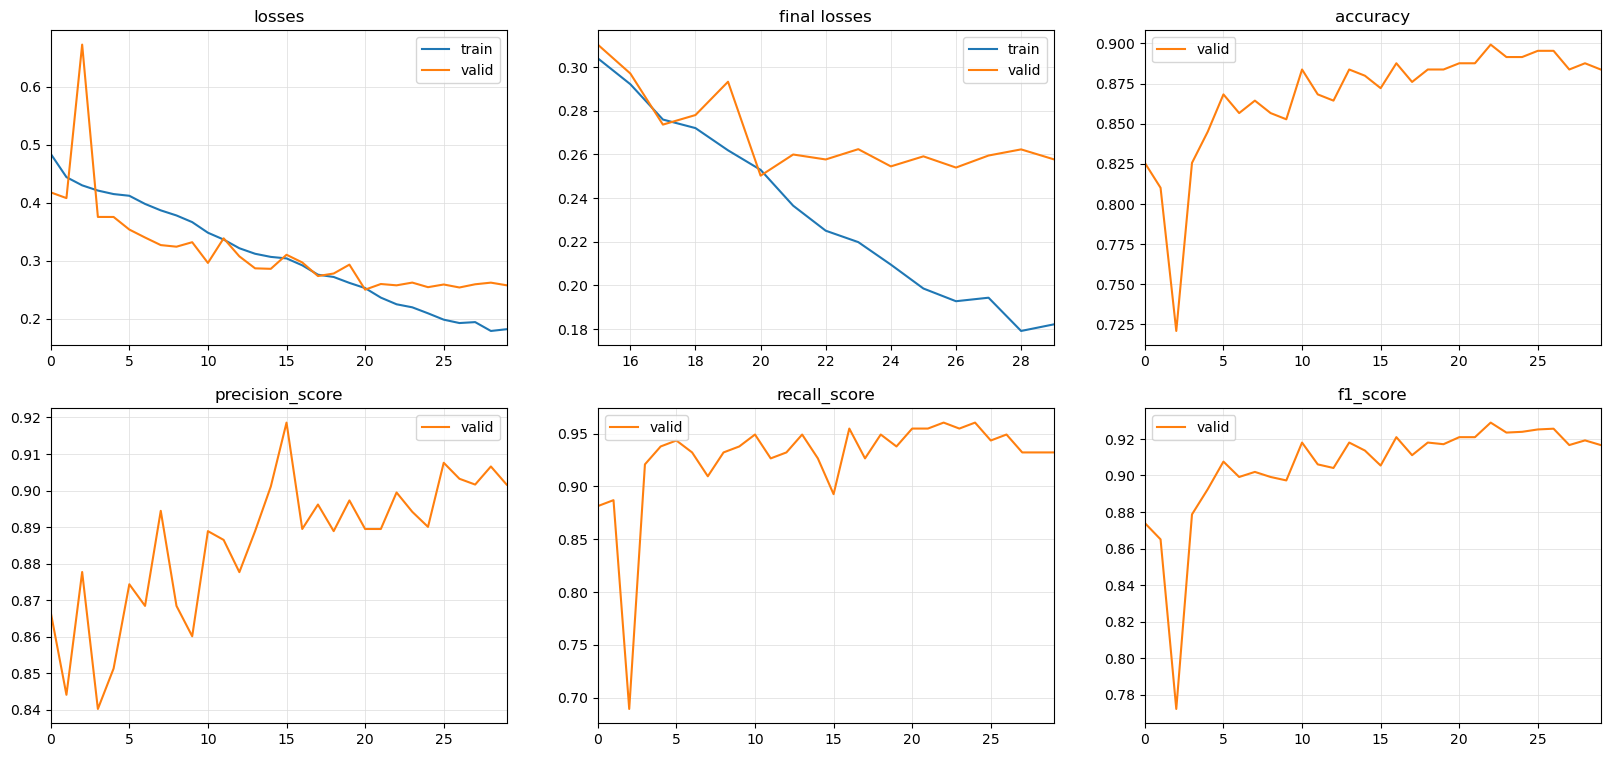

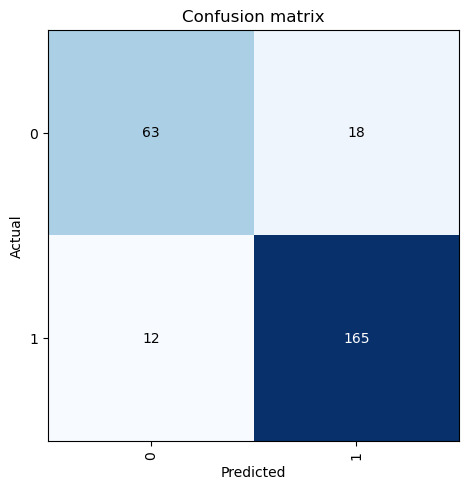

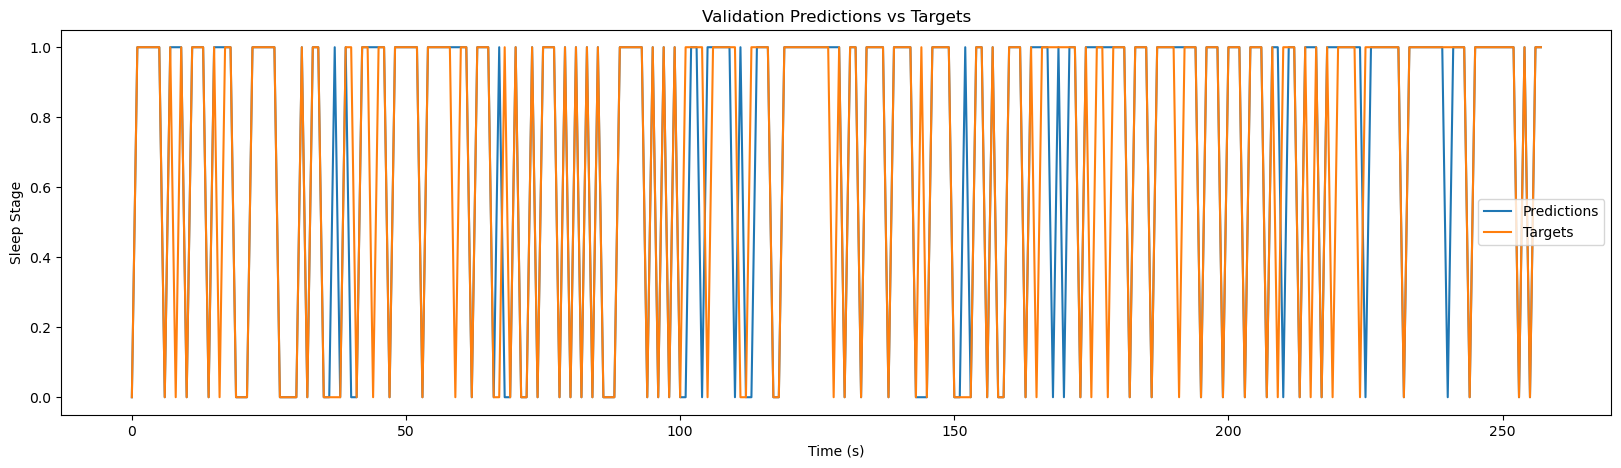

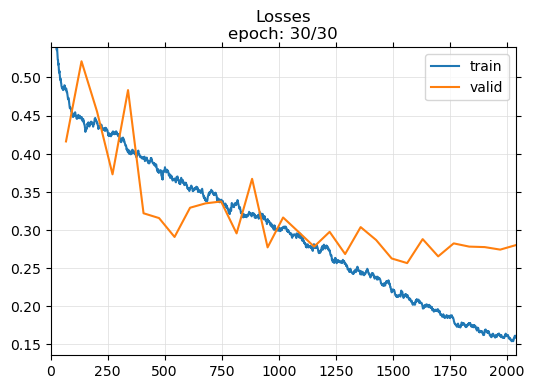

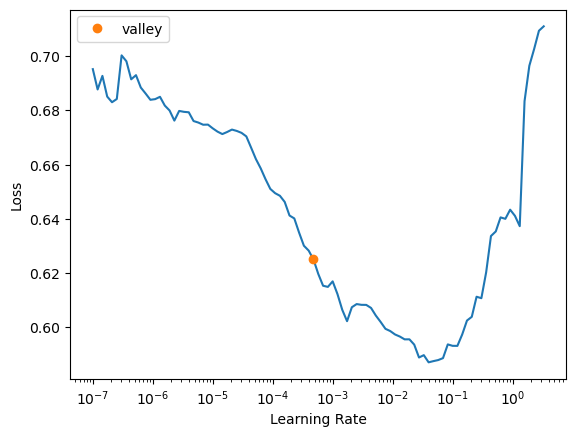

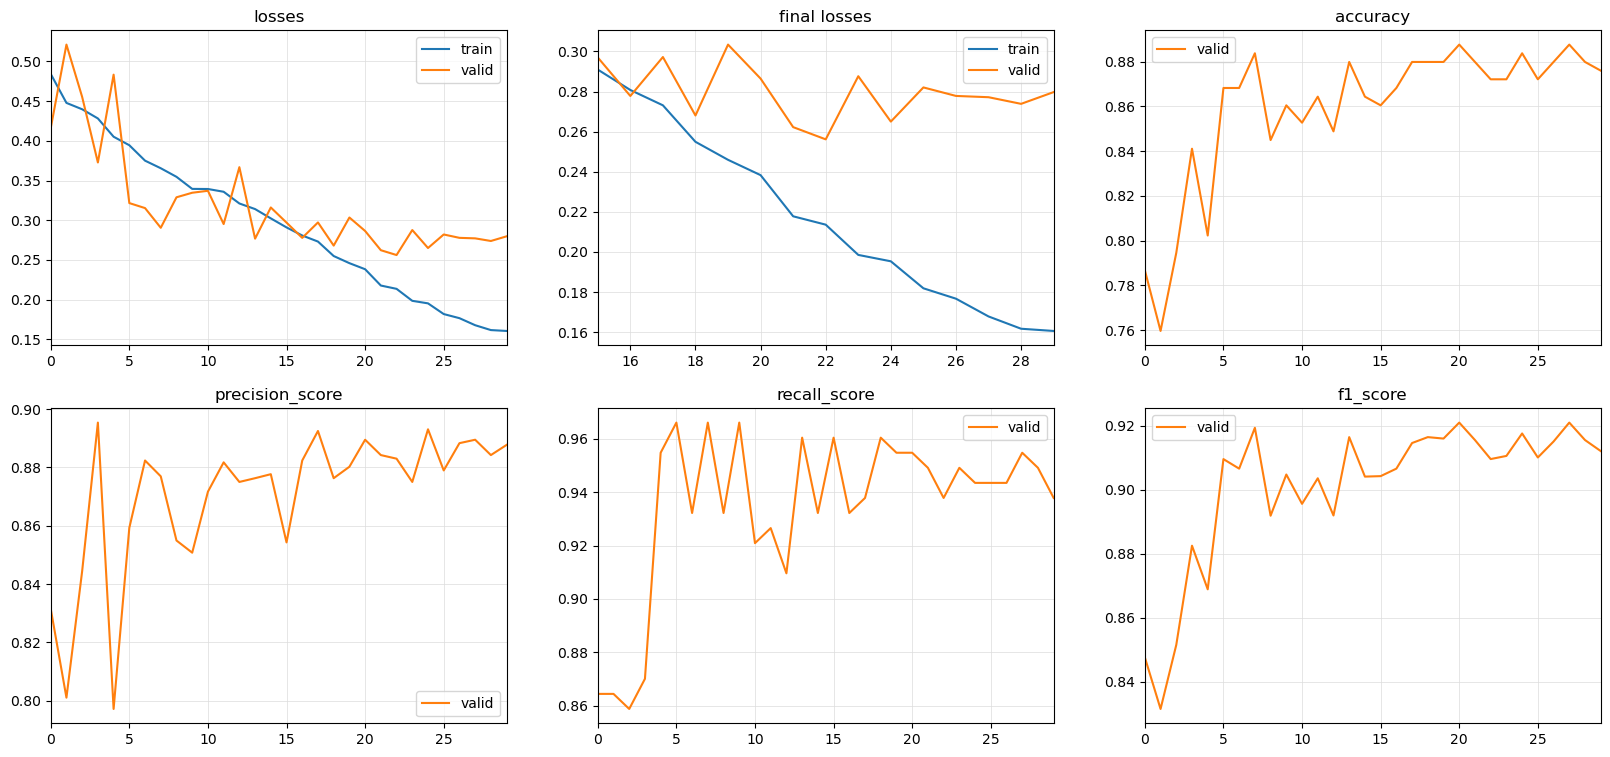

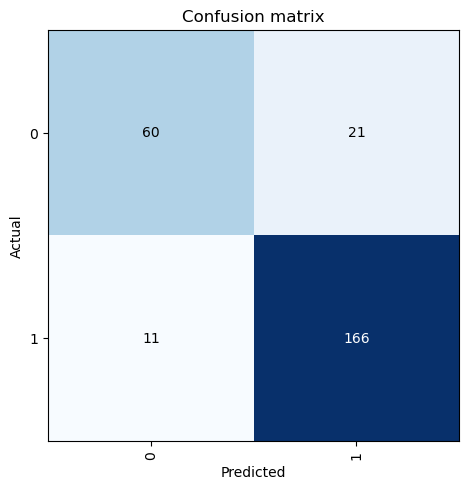

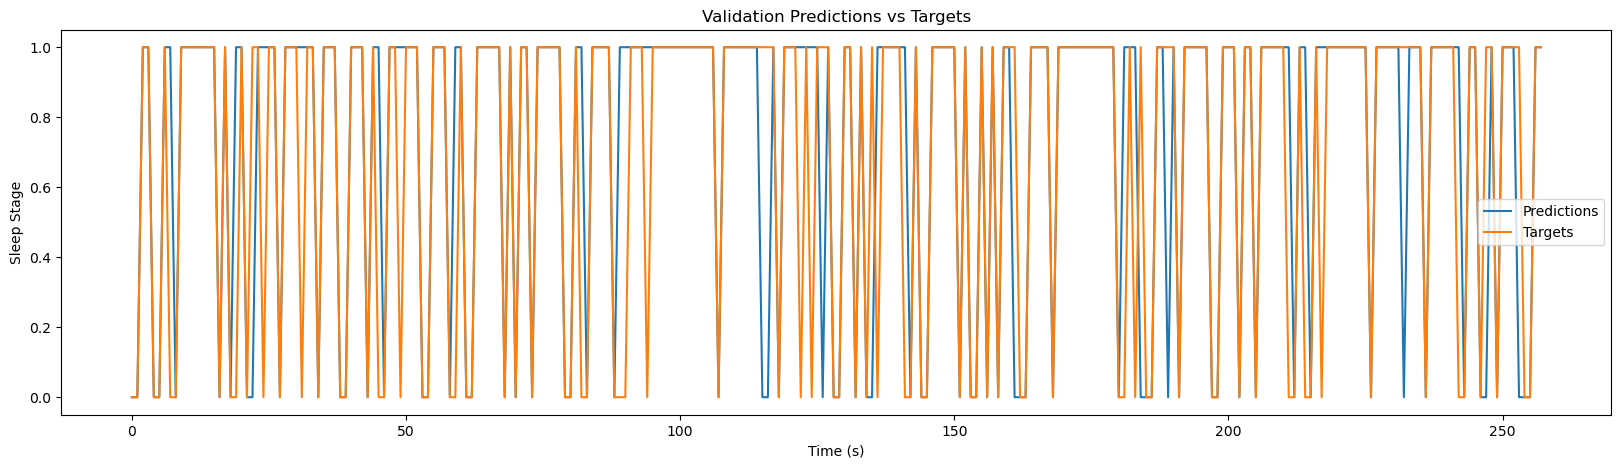

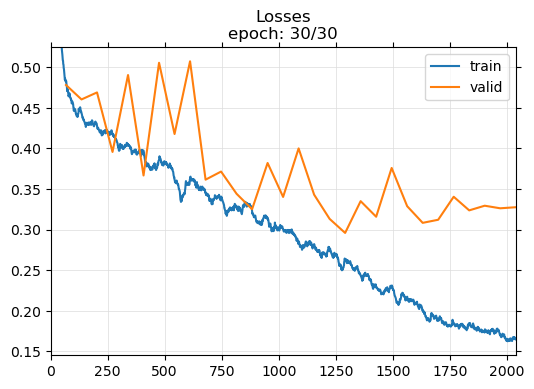

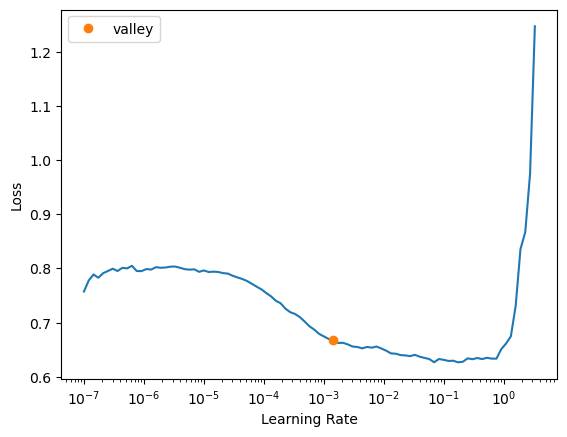

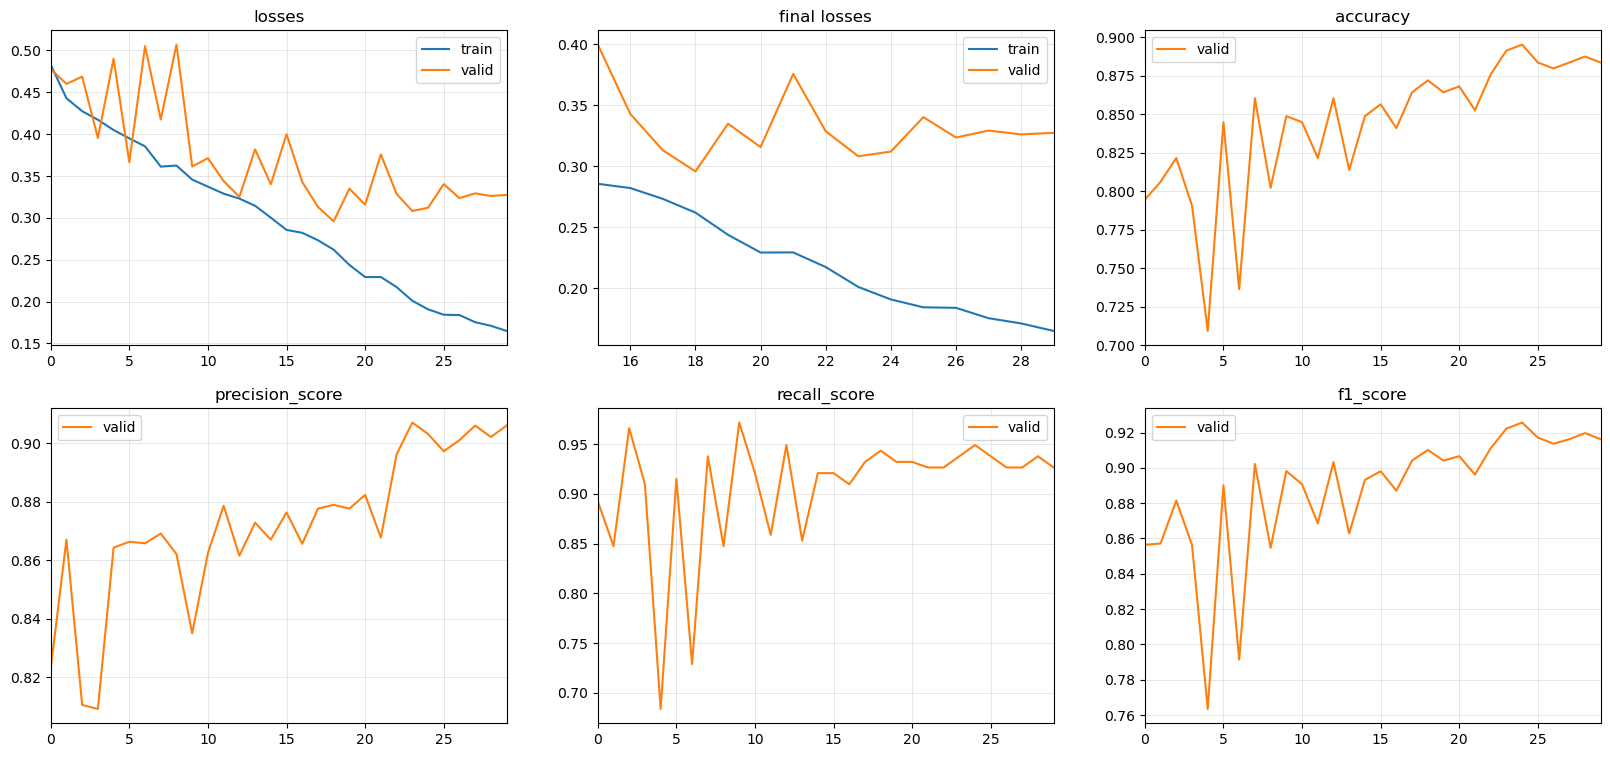

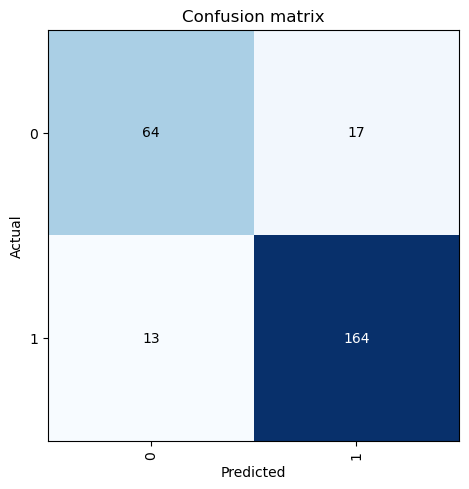

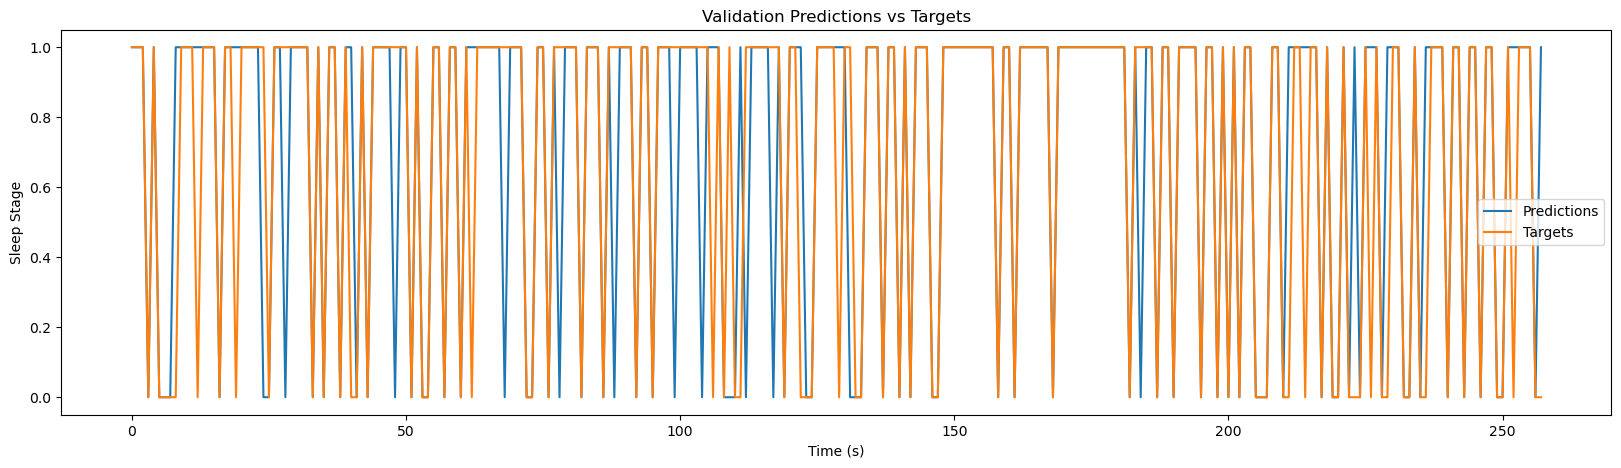

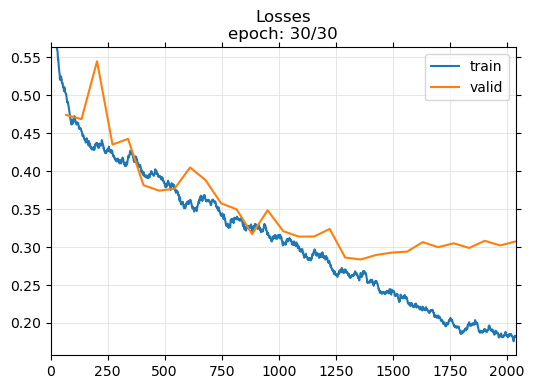

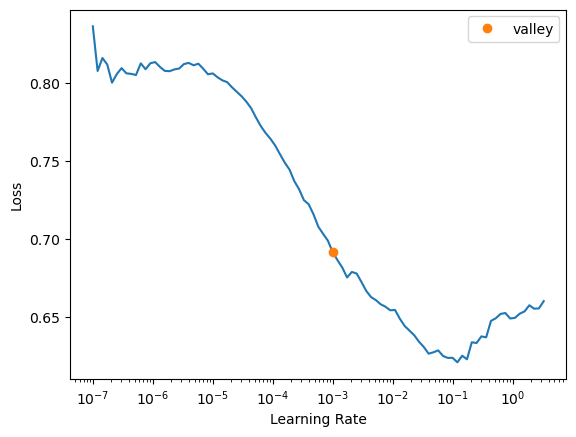

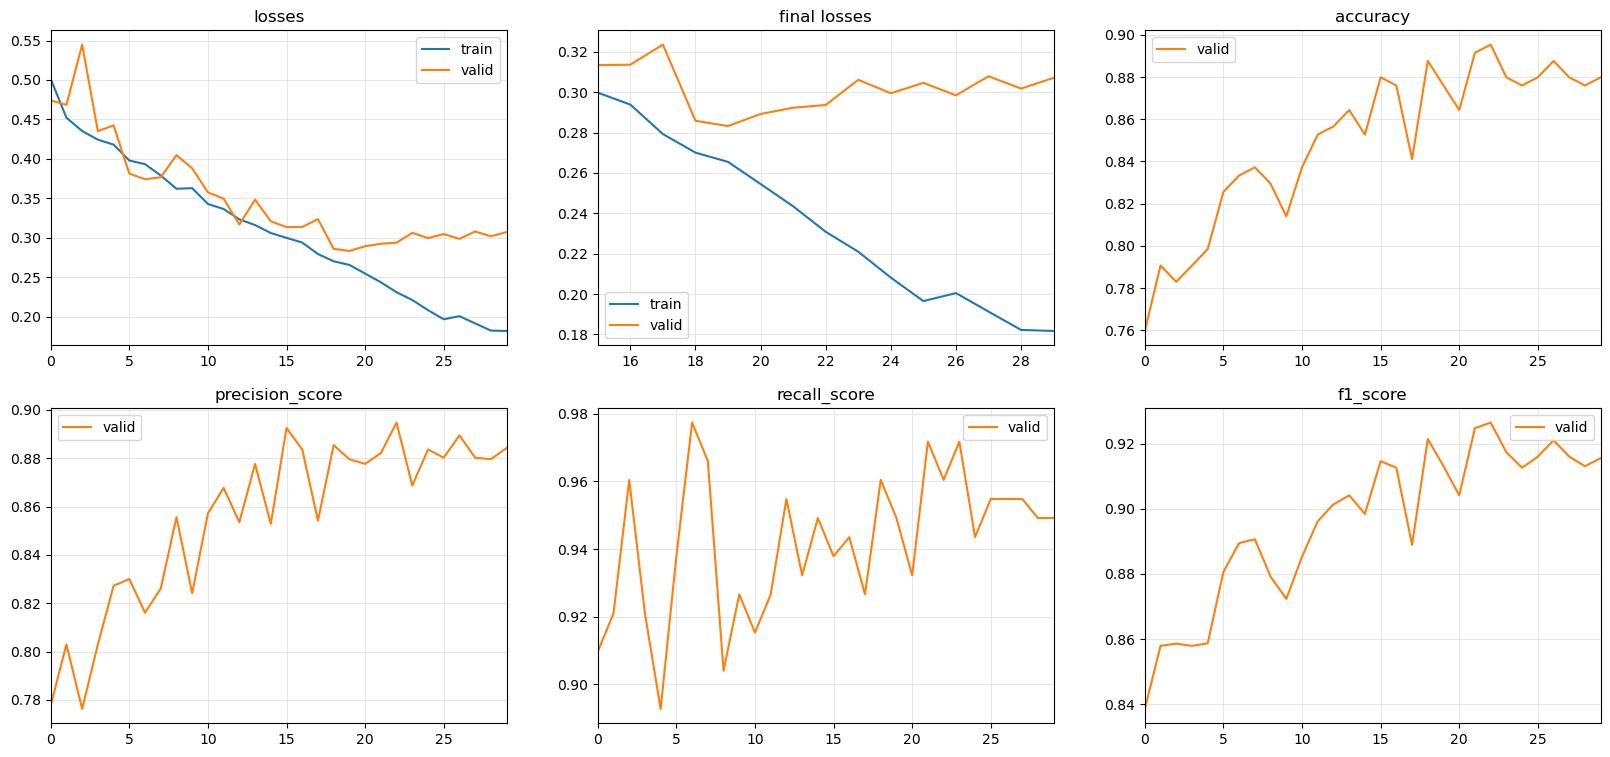

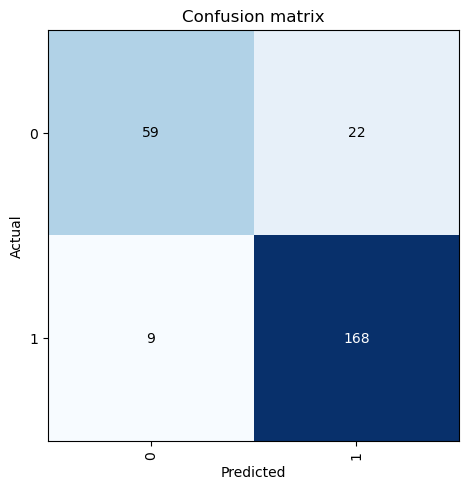

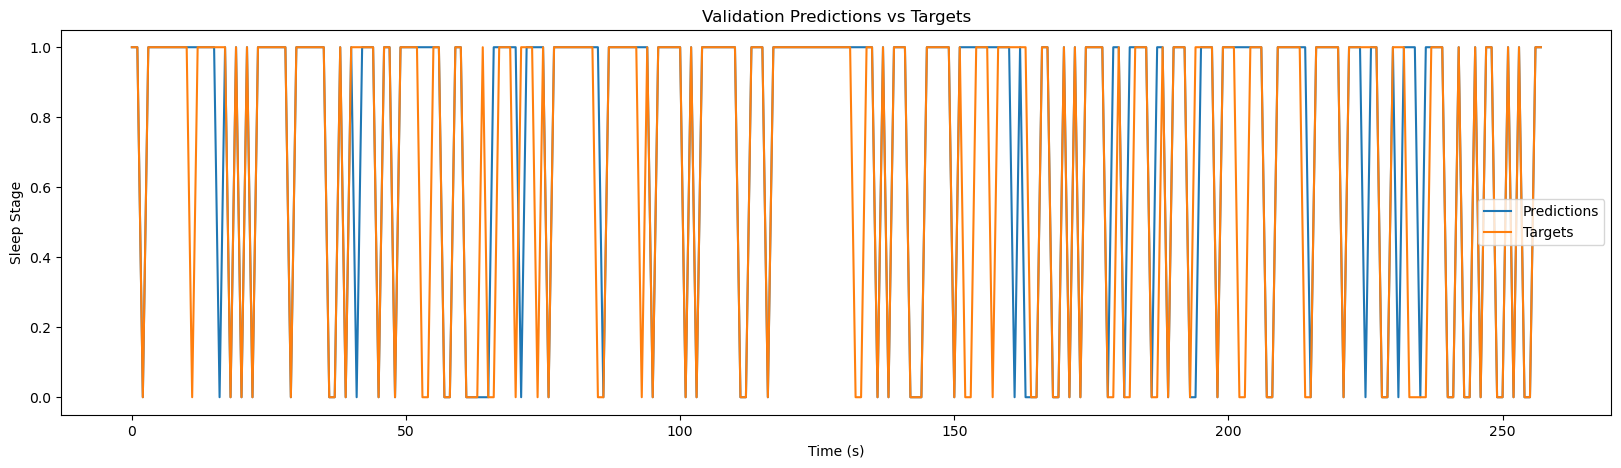

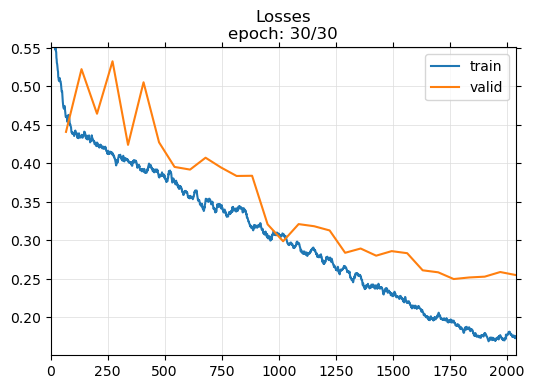

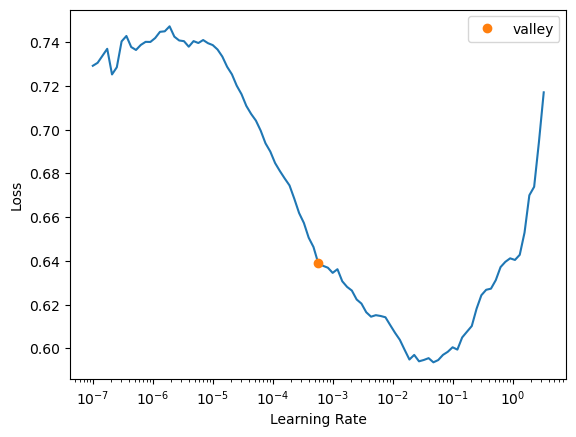

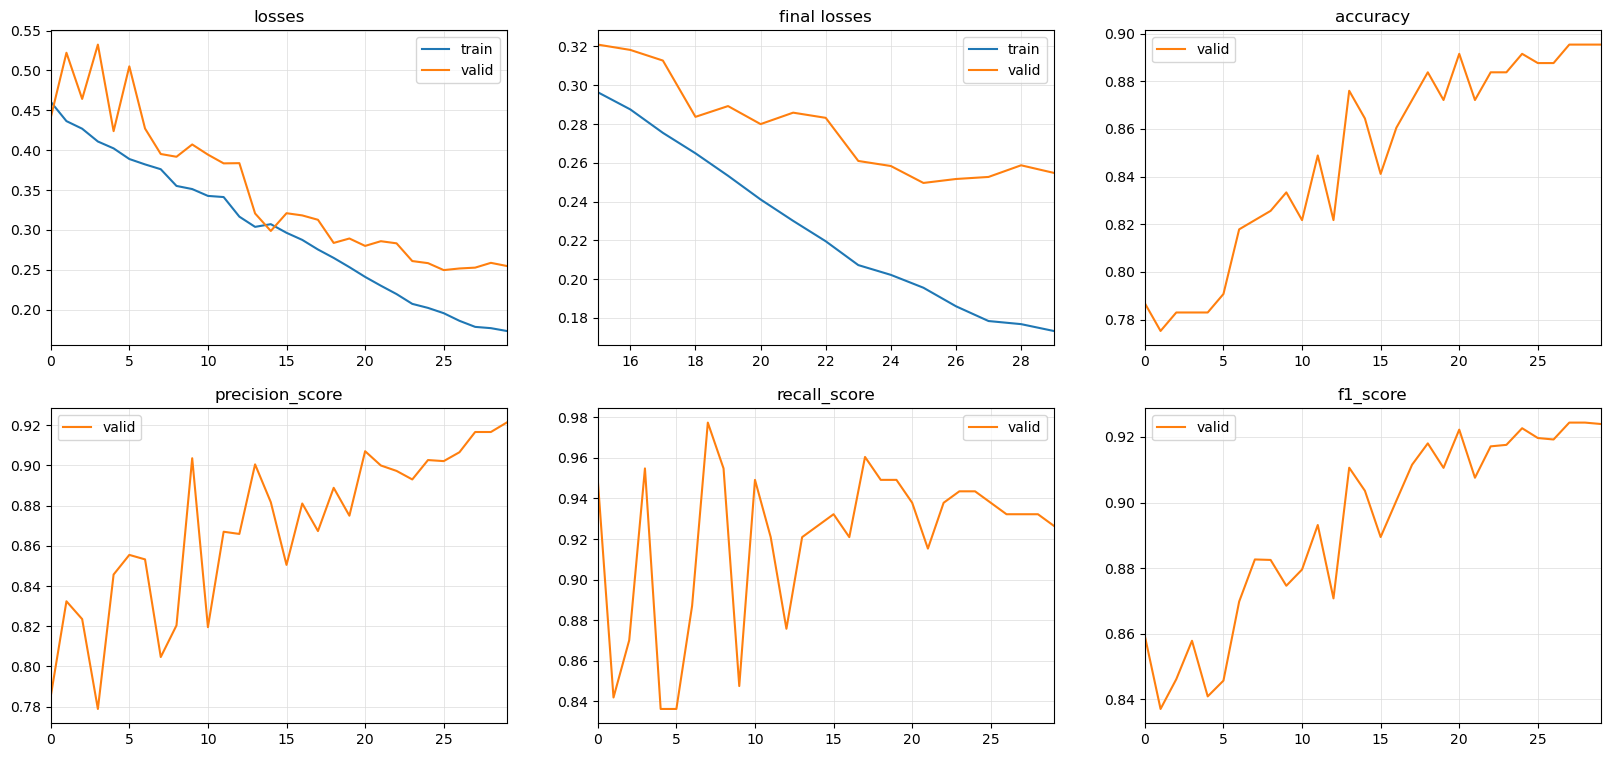

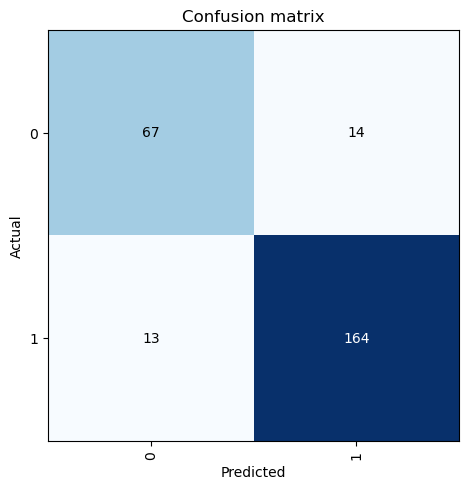

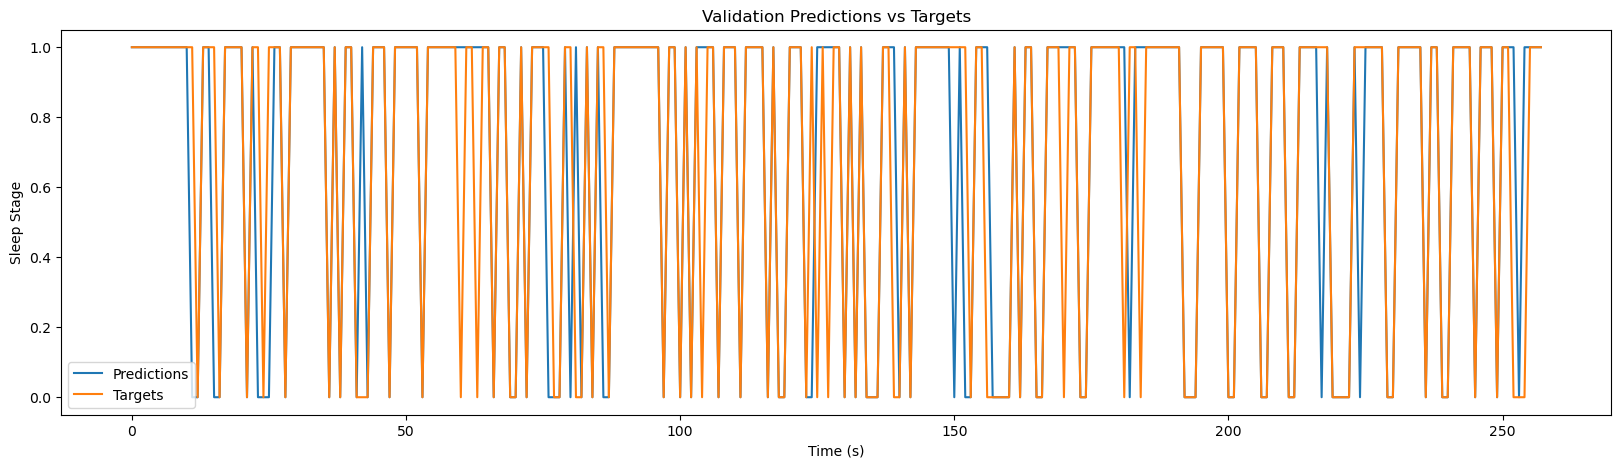

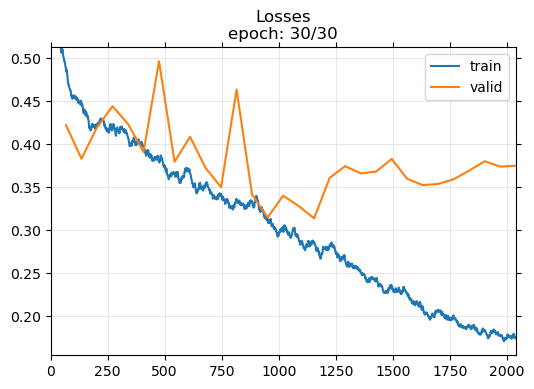

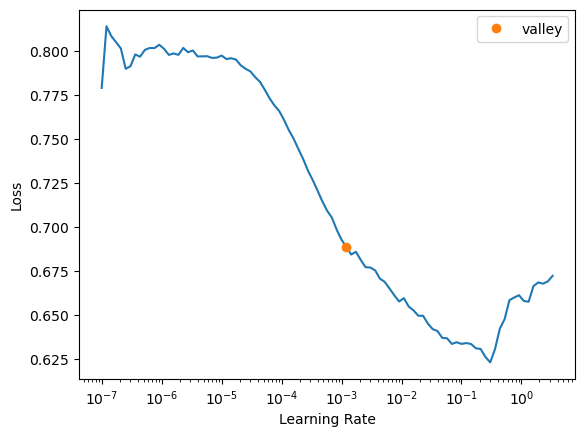

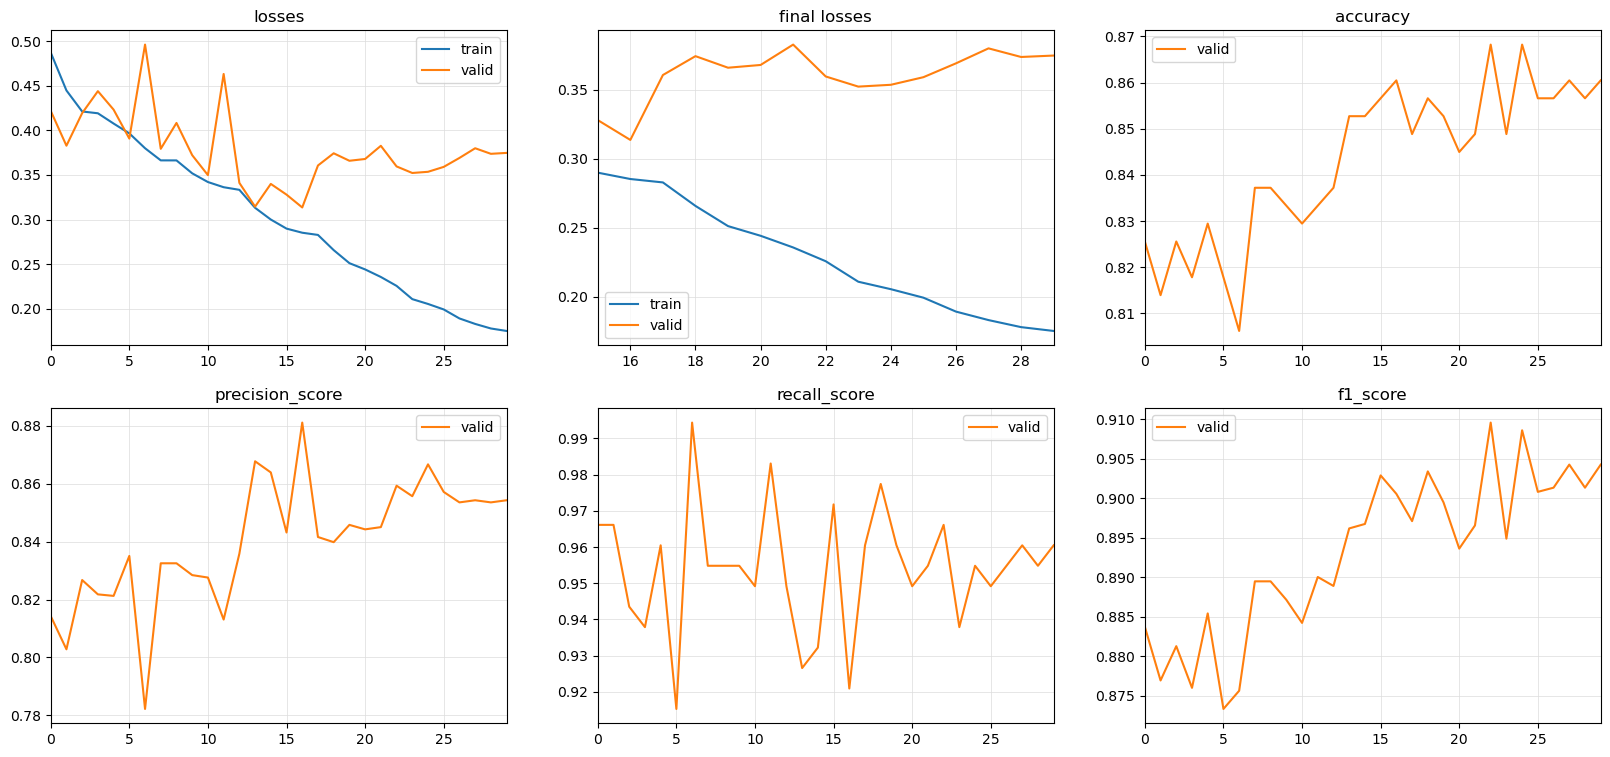

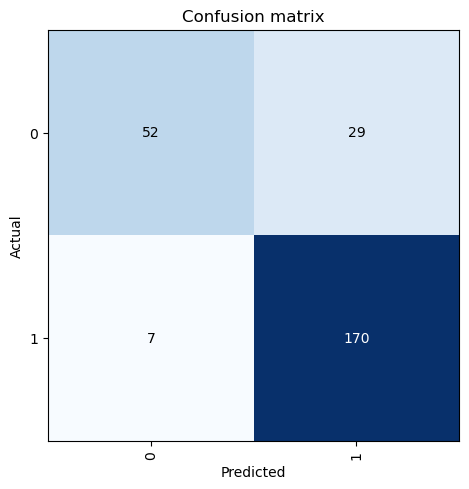

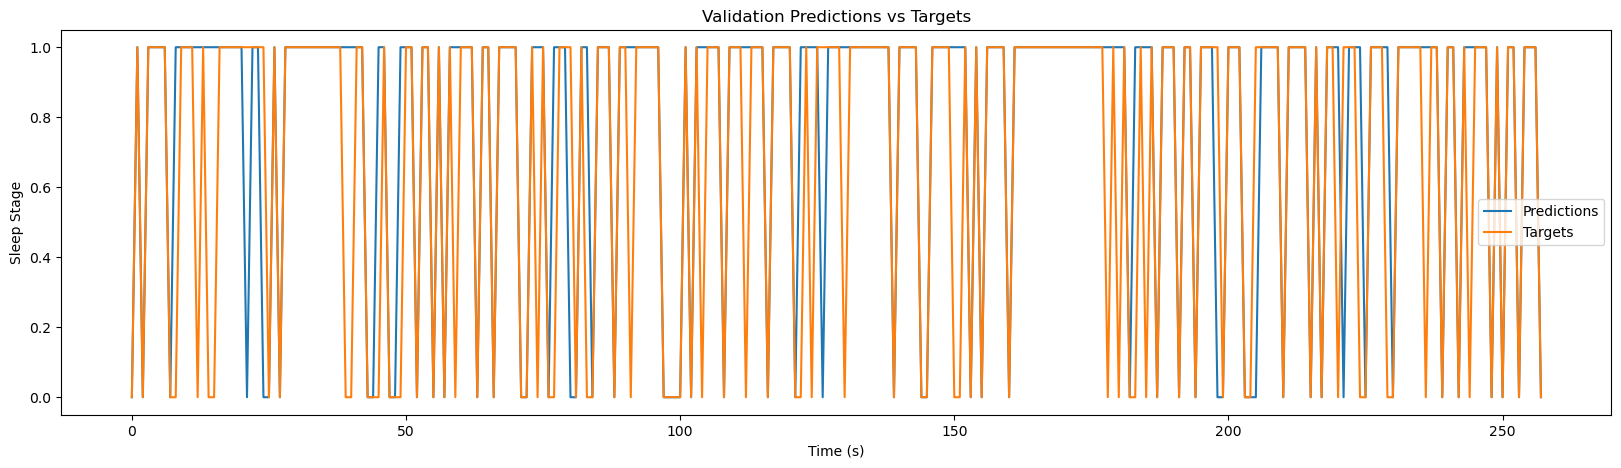

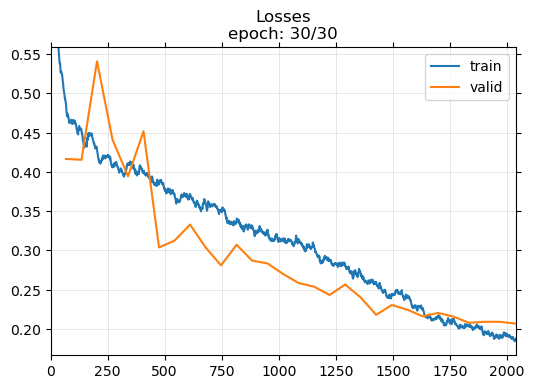

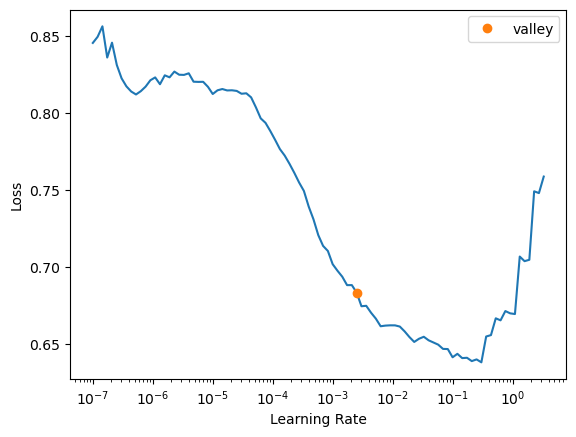

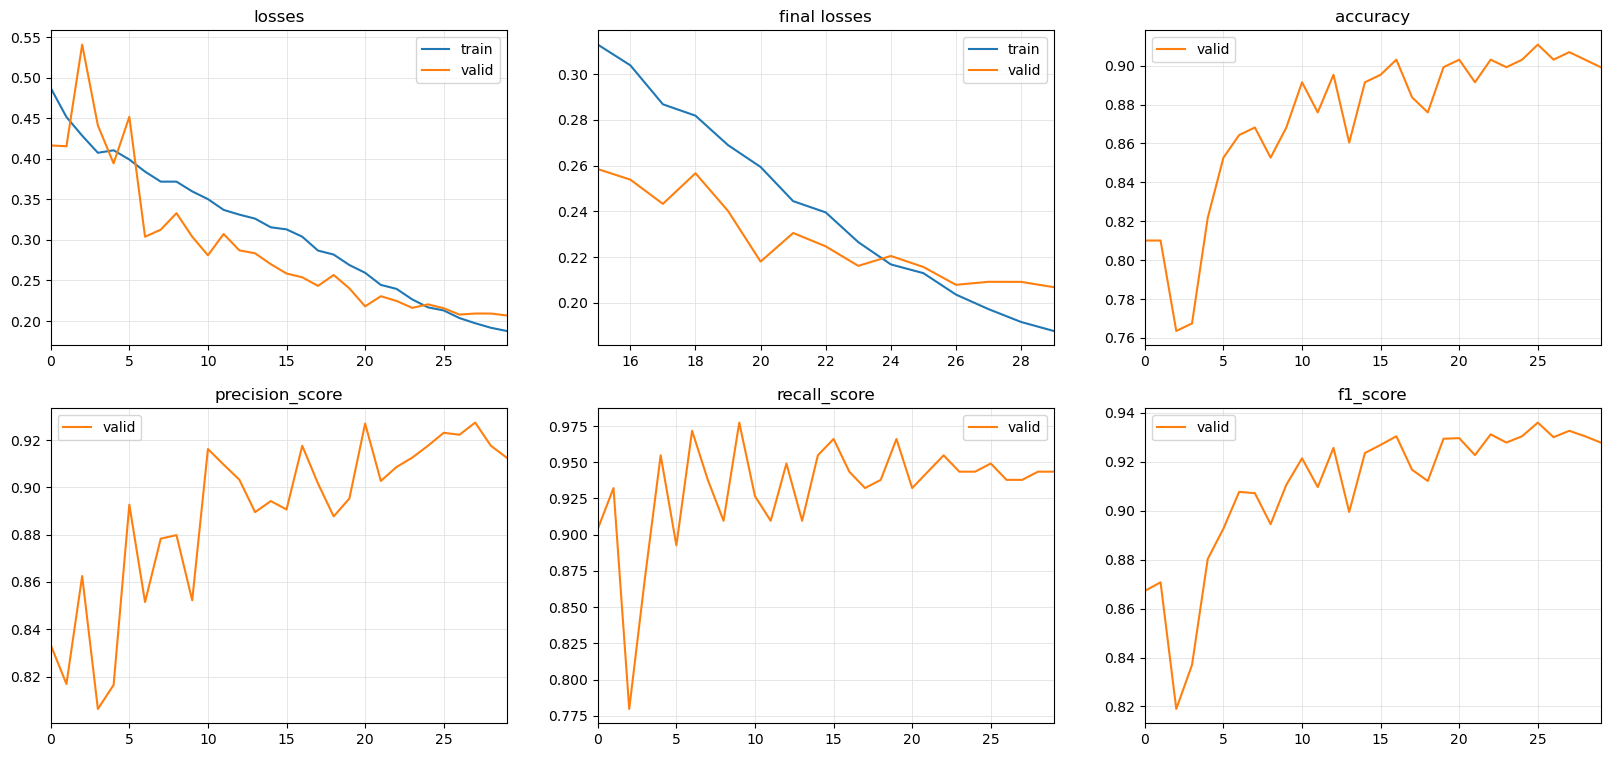

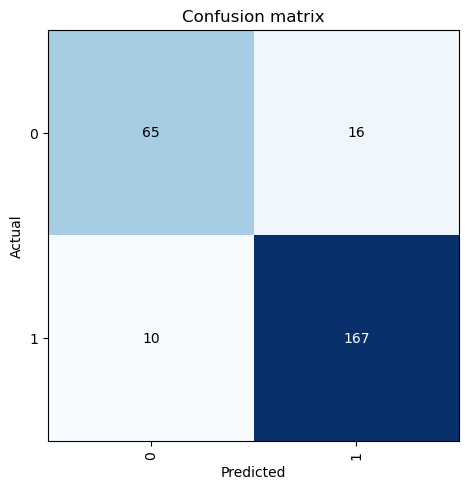

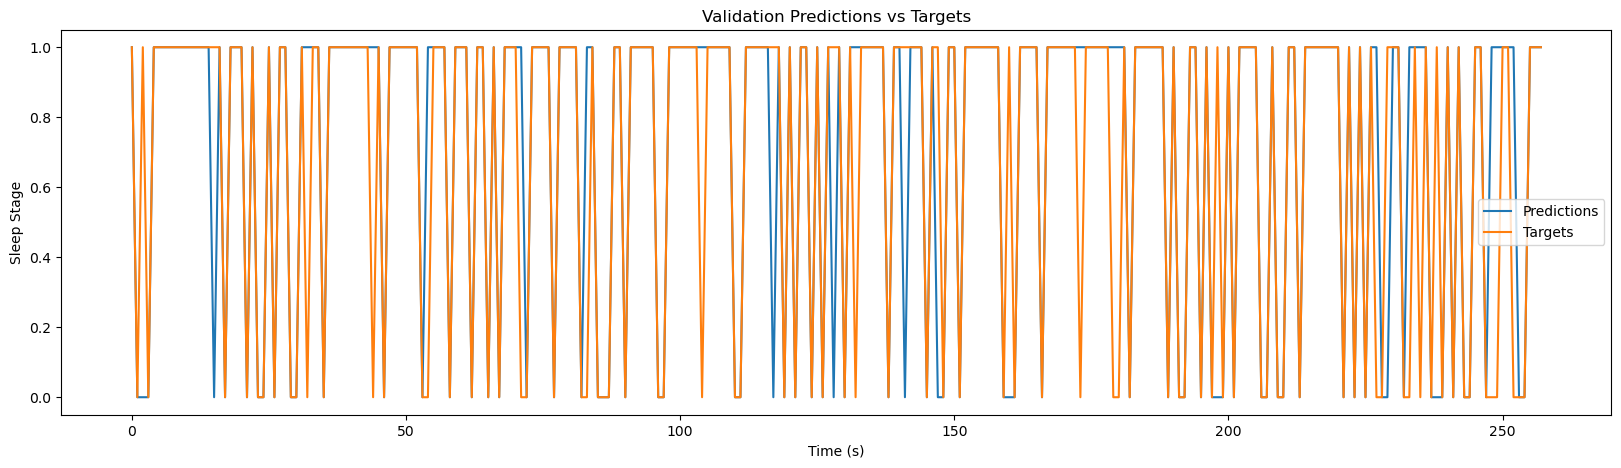

In [22]:
metrics = [accuracy, Precision(), Recall(), F1Score()]

def train_and_evaluate_it(X, y, splits, bs, lr, epochs):
    tfms = [None, [Categorize()]]
    dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
    dls = TSDataLoaders.from_dsets(dsets.train,
                                   dsets.valid,
                                   bs=bs,
                                   batch_tfms=[TSStandardize()],
                                   num_workers=0)
    # model = build_ts_model(InceptionTimePlus, dls=dls, **{'fc_dropout': 0.5})
    model = build_ts_model(InceptionTimePlus, dls=dls)
    learn = ts_learner(dls, model, metrics=metrics, cbs=ShowGraph())
    learn.lr_find()
    learn.fit_one_cycle(epochs, lr_max=lr)

    # Get predictions
    dls = learn.dls
    valid_dl = dls.valid
    valid_probas, valid_targets, valid_preds = learn.get_preds(dl=valid_dl, with_decoded=True)

    # # Test Set
    # X_test, y_test = X[splits[0][2]], y[splits[0][2]]
    # # Labelled test data
    # test_ds = valid_dl.dataset.add_test(X_test)
    # test_dl = valid_dl.new(test_ds)
    # test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True)
    # test_targets = y_test

    # print("Validation Accuracy: ", accuracy(valid_preds, valid_targets))
    # print("Validation Precision: ", Precision()(valid_preds, valid_targets))
    # print("Validation Recall: ", Recall()(valid_preds, valid_targets))

    # print("Test Accuracy: ", accuracy(test_preds, test_targets))
    # print("Test Precision: ", Precision()(test_preds, test_targets))
    # print("Test Recall: ", Recall()(test_preds, test_targets))

    # Plot confusion matrix
    interp = ClassificationInterpretation.from_learner(learn)
    interp.plot_confusion_matrix()

    # plot hypnogram of the predictions and the targets
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.plot(valid_preds, label='Predictions')
    ax.plot(valid_targets, label='Targets')
    ax.legend()
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Sleep Stage')
    ax.set_title('Validation Predictions vs Targets')
    plt.show()

    # # plot hypnogram of the predictions and the targets
    # fig, ax = plt.subplots(figsize=(20, 5))
    # ax.plot(test_preds, label='Predictions')
    # ax.plot(test_targets, label='Targets')
    # ax.legend()
    # ax.set_xlabel('Time (s)')
    # ax.set_ylabel('Sleep Stage')
    # ax.set_title('Test Predictions vs Targets')
    # plt.show()


splits = get_splits(y,
                    n_splits=18,
                    # test_size=0.0625,
                    shuffle=True,
                    stratify=True,
                    check_splits=True)


for s in splits:
    train_and_evaluate_it(X, y, s, [64, 128], 0.003, 30)

##### Save model

In [ ]:
# learn.save('all_features')

In [ ]:
# learn.save_all(path='export_all',
#                dls_fname='dls',
#                model_fname='model',
#                learner_fname='learner')

## Inferece


In [ ]:
# learn = load_learner_all(path='export_rmmsd',
#                          dls_fname='dls',
#                          model_fname='model',
#                          learner_fname='learner')

dls = learn.dls
valid_dl = dls.valid
b = next(iter(valid_dl))
b

In [ ]:
valid_probas, valid_targets, valid_preds = learn.get_preds(dl=valid_dl,
                                                           with_decoded=True)
valid_probas, valid_targets, valid_preds

In [ ]:
(valid_targets == valid_preds).float().mean()

In [ ]:
learn.show_results()


In [ ]:
learn.show_probas()


In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()


In [ ]:
# plot hypnogram of the predictions and the targets
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(valid_preds, label='Predictions')
ax.plot(valid_targets, label='Targets')
ax.legend()
ax.set_xlabel('Time (s)')
ax.set_ylabel('Sleep Stage')
ax.set_title('Predictions vs Targets')
plt.show()

In [ ]:
interp.most_confused(min_val=3)

In [ ]:
print(f'accuracy: {skm.accuracy_score(valid_targets, valid_preds):10.6f}')

# inference on unseen data

In [ ]:
# Read the data
test_data = pd.read_csv('final_test_processed.csv', index_col=0)

test_data = test_data[test_data.sleep_state != -1]

# Binary Classification
test_data["sleep_state"] = np.where(test_data["sleep_state"] == 0, 0, 1)

# fill NaN values
test_data = test_data.fillna(method='bfill', limit=1500).dropna()

# # set column time as datetime index
# df['time'] = pd.to_datetime(df['time'])
# df = df.set_index('time', drop=True)

test_data = test_data[['ledGreen', 'bpm', 'rmssd', 'pnn20', 'pnn50', 'hr_mad', 'sd1', 'sd2', 'accelerometerX', 'accelerometerY', 'accelerometerZ', 'gyroscopeX', 'gyroscopeY', 'gyroscopeZ', 'sleep_state']]


# remove extreme values from the signal (outliers)
test_filtered_ppg = remove_extreme_values(test_data['ledGreen'], threshold=3.0)
test_filtered_bpm = remove_extreme_values(test_data['bpm'], threshold=3.0)
test_filtered_rmssd = remove_extreme_values(test_data['rmssd'], threshold=3.0)
test_filtered_pnn20 = remove_extreme_values(test_data['pnn20'], threshold=3.0)
test_filtered_pnn50 = remove_extreme_values(test_data['pnn50'], threshold=3.0)
test_filtered_hr_mad = remove_extreme_values(test_data['hr_mad'], threshold=3.0)
test_filtered_sd1 = remove_extreme_values(test_data['sd1'], threshold=3.0)
test_filtered_sd2 = remove_extreme_values(test_data['sd2'], threshold=3.0)
test_filtered_accelerometerX = remove_extreme_values(test_data['accelerometerX'],
                                                threshold=3.0)
test_filtered_accelerometerY = remove_extreme_values(test_data['accelerometerY'],
                                                threshold=3.0)
test_filtered_accelerometerZ = remove_extreme_values(test_data['accelerometerZ'],
                                                threshold=3.0)
test_filtered_gyroscopeX = remove_extreme_values(test_data['gyroscopeX'], threshold=3.0)
test_filtered_gyroscopeY = remove_extreme_values(test_data['gyroscopeY'], threshold=3.0)
test_filtered_gyroscopeZ = remove_extreme_values(test_data['gyroscopeZ'], threshold=3.0)

test_data['ledGreen'] = test_filtered_ppg
test_data['bpm'] = test_filtered_bpm
test_data['rmssd'] = test_filtered_rmssd
test_data['pnn20'] = test_filtered_pnn20
test_data['pnn50'] = test_filtered_pnn50
test_data['hr_mad'] = test_filtered_hr_mad
test_data['sd1'] = test_filtered_sd1
test_data['sd2'] = test_filtered_sd2
test_data['accelerometerX'] = test_filtered_accelerometerX
test_data['accelerometerY'] = test_filtered_accelerometerY
test_data['accelerometerZ'] = test_filtered_accelerometerZ
test_data['gyroscopeX'] = test_filtered_gyroscopeX
test_data['gyroscopeY'] = test_filtered_gyroscopeY
test_data['gyroscopeZ'] = test_filtered_gyroscopeZ

test_data = test_data.dropna()

plt.plot(test_filtered_ppg)

In [ ]:
test_data

In [ ]:
scaler = RobustScaler()
le = LabelEncoder()

X_test = scaler.fit_transform(test_data.drop('sleep_state', axis=1))
y_test = le.fit_transform(test_data['sleep_state'])

# selecting sequences range
X_test = X_test[0:(len(X_test) - len(X_test) % 1500)]
y_test = y_test[0:(len(y_test) - len(y_test) % 1500)]


In [ ]:
# reshape the data to tsai format
X_test = X_test.reshape(-1, 1500, 14)
X_test = X_test.transpose(0, 2, 1)
y_test = y_test.reshape(-1, 1500)
y_test = (y_test.sum(axis=1) // 1500).reshape(-1, 1).flatten()

print(X_test.shape, y_test.shape)

pd.DataFrame(X_test[0]).head()

In [ ]:
# Labelled test data
test_ds = valid_dl.dataset.add_test(X_test) 
test_dl = valid_dl.new(test_ds)
next(iter(test_dl))

In [ ]:
test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl,
                                                        with_decoded=True,
                                                        save_preds=None,
                                                        save_targs=None)
test_probas, test_targets, test_preds


In [ ]:
print(f'accuracy: {skm.accuracy_score(y_test, test_preds):10.6f}')

In [ ]:
learn.show_results()


In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

#### If unlabelled data

In [ ]:
# Unlabelled data
test_ds = dls.dataset.add_test(X)
test_dl = valid_dl.new(test_ds)
next(iter(test_dl))

In [ ]:
test_probas, *_ = learn.get_preds(dl=test_dl, save_preds=None)
test_probas
